In [18]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load brainspan data

I need to come back here and add the things I did to make these notebooks

In [2]:
# Where to save figures
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/'

In [396]:
df = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/gene_expression_original.csv',
                     )
rmd = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/gene_metadata_original.csv')
cmd = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/samples_metadata.csv')

KeyboardInterrupt: 

In [ ]:
# df = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/expression_matrix.csv',header=None)
# rmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/rows_metadata.csv')
# cmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/columns_metadata.csv')

# Load component data

In [5]:
# c1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCORR_C1_genelist.csv',
#                     index_col=0)
# c1.columns = ['expr'] + c1.columns[1:].tolist()
# c2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C2_genelist.csv',
#                     index_col=0)
# c2.columns = ['expr'] + c2.columns[1:].tolist()
# c2 = c2.sort_values('expr',ascending=True)
# c3 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C3_genelist.csv',
#                     index_col=0)


In [6]:
c1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCORR_C1_genelist.csv',
                    index_col=0)
c1.columns = ['expr'] + c1.columns[1:].tolist()
c1 = c1.sort_values('expr',ascending=True)
c2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C2_genelist.csv',
                    index_col=0)
c2.columns = ['expr'] + c2.columns[1:].tolist()
c2 = c2.sort_values('expr',ascending=True)
c3 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C3_genelist.csv',
                    index_col=0)
c3.columns = ['expr'] + c3.columns[1:].tolist()
c3 = c3.sort_values('expr',ascending=True)

In [7]:
len(rmd.gene_symbol.unique())

47808

#### address duplicates

In [8]:
dups = []
dind = []
catch = []
for i,row in rmd.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

It appears most uniques are RNA or things we dont care about. I will remove them

In [9]:
df.shape

(52376, 525)

In [10]:
bad_index = rmd[rmd.gene_symbol.isin(dups)].index
rmd.drop(bad_index,inplace=True)
df.drop(bad_index,inplace=True)

#### harmonize genes

In [509]:
np.std([30,23,36,37,40,21])

7.151145984308311

In [506]:
subsum[subsum.Age_Stage=='adult'].age

12960    30 yrs
12287    23 yrs
12837    36 yrs
12879    37 yrs
12880    40 yrs
12290    21 yrs
Name: age, dtype: object

In [11]:
shared = list(set(rmd.gene_symbol.values) & set(c1.gene_symbol))
len(shared)

13750

In [12]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(13750, 525)

In [13]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

0          1          2          3          4          5  \
TSPAN6    36.447128  24.251253  19.330479  27.668607  19.998231  14.680673   
DPM1      34.373239  20.765661  18.734947  22.366394  19.228431  11.020365   
SCYL3      4.379337   4.227521   2.551825   3.603764   2.948976   2.405183   
C1orf112   3.957119   3.520794   2.037805   3.487035   2.177235   0.999693   
FGR        0.244174   0.266976   0.248188   0.141398   0.467688   0.296493   

                  6          7          8          9  ...        514  \
TSPAN6    27.548101  16.580183  44.587799  44.943915  ...   2.320932   
DPM1      25.394607  17.671327  32.903100  38.157569  ...  23.769167   
SCYL3      3.613642   2.573935   3.483817   3.609830  ...   1.593009   
C1orf112   3.481555   1.747568   3.741580   3.560650  ...   0.583488   
FGR        0.079941   0.149822   0.204210   0.260205  ...   1.319251   

                515        516        517        518        519        520  \
TSPAN6     1.781548   2.277359   1.832737   1.555696   2.081944   3.484685   
DPM1      20.142132  20.063257  16.575379  18.783516  21.631293  28.006120   
SCYL3      1.563377   1.648571   2.231466   2.040326   2.161741   1.275352   
C1orf112   0.797376   0.607141   0.575555   0.606445   0.683625   0.495084   
FGR        2.062175   1.168233   0.681609   0.490367   0.407953   1.568014   

                521        522        523  
TSPAN6     4.816781   3.034464   3.082820  
DPM1      28.731717  16.679597  28.866042  
SCYL3      1.184766   1.735579   1.500363  
C1orf112   0.761265   0.766482   0.468859  
FGR        1.260039   1.736395   1.632879  

[5 rows x 524 columns]

#### Get gene expression for each component and each columns

In [14]:
gdf = pandas.DataFrame(cmd,copy=True)

In [425]:
c1.index = c1.gene_symbol.values
c2.index = c2.gene_symbol.values
c3.index = c3.gene_symbol.values
for i,col in enumerate(gxp.columns):
    gdf.loc[i,'C1_exp'] = np.dot(gxp[col],
                                 c1.loc[gxp.index,'expr'].values)
    gdf.loc[i,'C2_exp'] = np.dot(gxp[col],
                                 c2.loc[gxp.index,'expr'].values)
    gdf.loc[i,'C3_exp'] = np.dot(gxp[col],
                                 c3.loc[gxp.index,'expr'].values)
    gdf.loc[i,'C1_absexp'] = np.dot(gxp[col],
                                 abs(c1.loc[gxp.index,'expr'].values))
    gdf.loc[i,'C2_absexp'] = np.dot(gxp[col],
                                 abs(c2.loc[gxp.index,'expr'].values))
    gdf.loc[i,'C3_absexp'] = np.dot(gxp[col],
                                 abs(c3.loc[gxp.index,'expr'].values))

In [17]:
#gdf.to_csv('data/GCorr_Brainspan.csv')

In [3]:
gdf = pandas.read_csv('data/GCorr_Brainspan.csv')

#### Prepare stuff for plots

In [5]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs',]
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


In [6]:
Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [7]:
# deal with the nine months before birth before logging...
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    gdf.loc[i,'age_in_months'] = fage

In [8]:
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num)
    elif measure == 'yrs':
        fage = (int(num) * 52) + 39.105
    else:
        fage = (int(num) * 4.345) + 39.105
    gdf.loc[i,'age_in_weeks'] = fage

In [9]:
gdf.loc[:,'log_age_months'] = np.log(gdf['age_in_months']).values
gdf.loc[:,'log_age_weeks'] = np.log(gdf['age_in_weeks']).values


In [10]:
as_order = ['fetal','infant','child','adolescent','adult']
ae_order = sorted(gdf.Age_Epoch.unique())
ap_order = gdf.Age_Period.unique()

In [11]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

In [12]:
rbpal = [sns.color_palette('cividis')[-1],
                      sns.color_palette('cividis')[0]]

# Plot component dispersion across brainspan

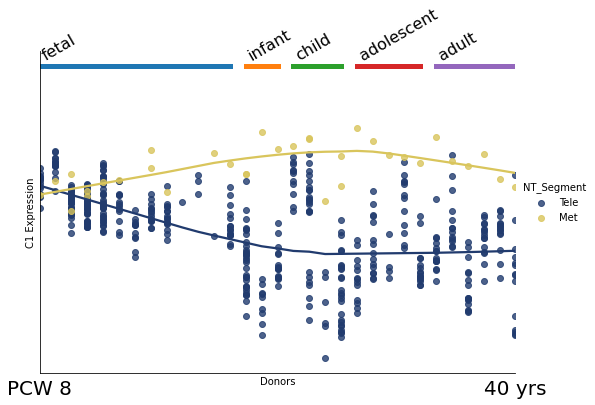

In [24]:
g = sns.lmplot(x='age_level',y='C1_exp',aspect=1.5,
               data=gdf,
               #[gdf['C1_exp']<1000],
           hue='NT_Segment',lowess=True,
              palette=rbpal[::-1])
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[100,100],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,110,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C1 Expression')
plt.yticks([])
plt.xlabel('Donors')
plt.xticks([])
plt.text(0,-1200,'PCW 8',fontsize=20,ha='center')
plt.text(30,-1200,'40 yrs',fontsize=20,ha='center')
#plt.xticks(ticks = range(len(gdf.age_level.unique())),
              #labels=order
          #)
plt.savefig(os.path.join(fig_dir,'BS_Devel_C1.pdf'),bbox_inches='tight')

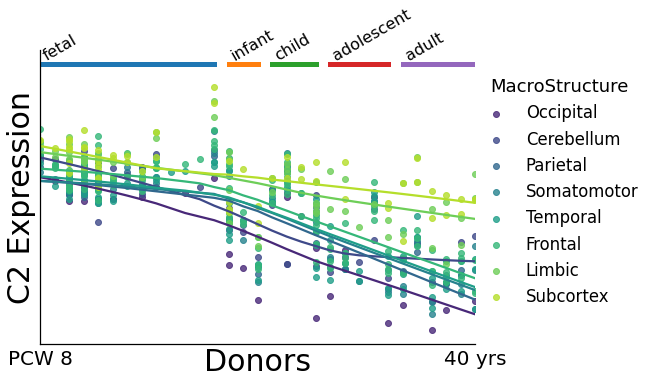

In [25]:
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='age_level',y='C2_exp',aspect=1.5,
               data=gdf[(gdf.MacroStructure!='GangEm') &\
                        (gdf['C2_exp']<1000)],
           hue='MacroStructure',lowess=True,
               hue_order=['Occipital','Cerebellum','Parietal','Somatomotor',
                          'Temporal','Frontal','Limbic','Subcortex'],
              palette='viridis')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[500,500],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,500,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('Donors',fontsize=30)
plt.xticks([])
plt.text(0,-400,'PCW 8',fontsize=20,ha='center')
plt.text(30,-400,'40 yrs',fontsize=20,ha='center')
plt.savefig(os.path.join(fig_dir,'BS_Devel_C2.pdf'),bbox_inches='tight')

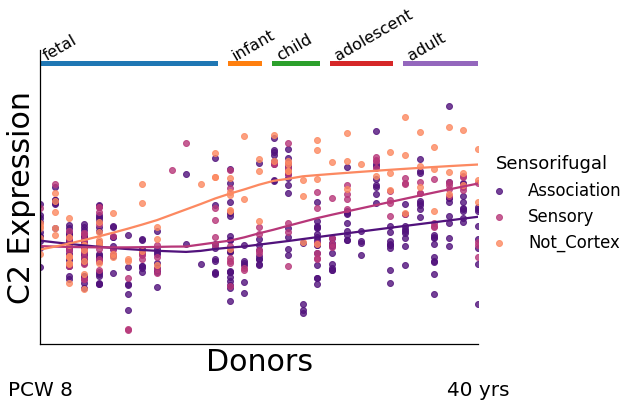

In [26]:
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='age_level',y='C3_exp',aspect=1.5,
               data=gdf[gdf.C3_exp<400],
           hue='Sensorifugal',lowess=True,
              palette='magma')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[150,150],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,150,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('Donors',fontsize=30)
plt.xticks([])
plt.text(0,-700,'PCW 8',fontsize=20,ha='center')
plt.text(30,-700,'40 yrs',fontsize=20,ha='center')
plt.savefig(os.path.join(fig_dir,'BS_Devel_C3.pdf'),bbox_inches='tight')

In [13]:
for i,row in gdf.iterrows():
    if row['Age_Epoch'] in ['e0','e1']:
        ag = 'Early_Prenatal'
    elif row['Age_Epoch'] == 'e3':
        ag = 'Perinatal'
    else:
        meas = row['age'].split(' ')[0]
        if int(meas) < 11:
            ag = 'Child'
        else:
            ag = 'Adolescent/Adult'
    gdf.loc[i,'new_age_gp'] = ag

for i,row in gdf.iterrows():
    if row['Age_Stage'] in ['infant','child']:
        ag = 'Infant/Child'
    elif row['Age_Stage'] in ['adolescent','adult']:
        ag = 'Adolescent/Adult'
    else:
        ag = row['Age_Stage']
    gdf.loc[i,'new_age_stage'] = ag

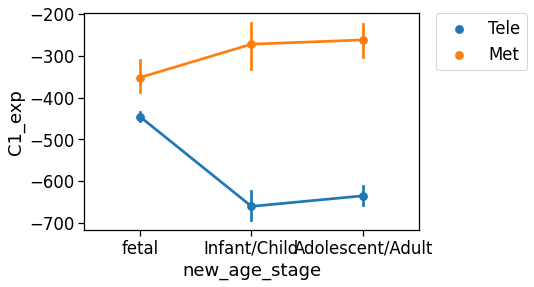

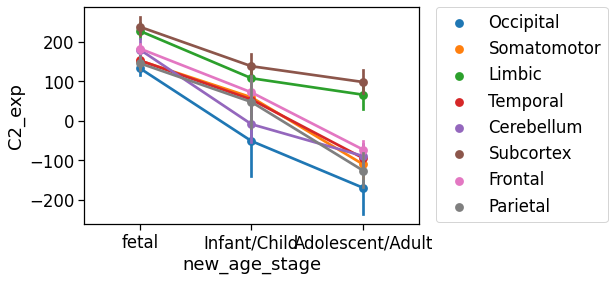

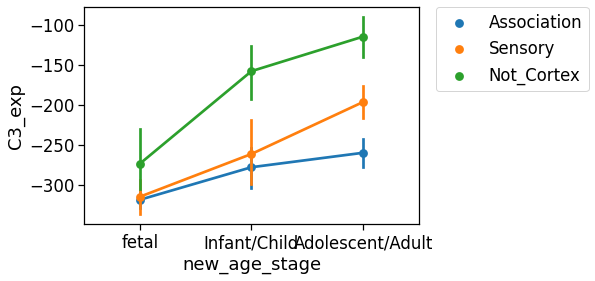

In [28]:
order = ['fetal','Infant/Child','Adolescent/Adult']
sns.pointplot(x='new_age_stage',y='C1_exp',hue='NT_Segment',
             data=gdf, order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
sns.pointplot(x='new_age_stage',y='C2_exp',hue='MacroStructure',
             data=gdf[gdf.MacroStructure!='GangEm'], order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
sns.pointplot(x='new_age_stage',y='C3_exp',hue='Sensorifugal',
             data=gdf, order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()




/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


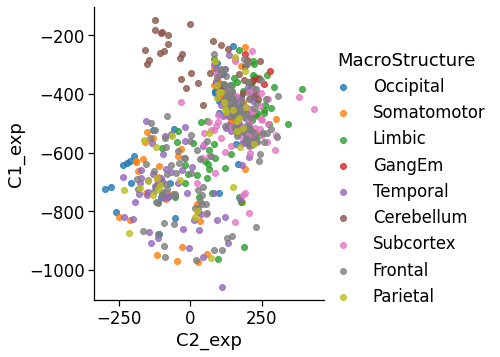

In [38]:
sns.lmplot('C2_exp','C1_exp',data=gdf,#[gdf.new_age_stage=='Adolescent/Adult'],
           hue='MacroStructure',
           fit_reg=False)

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


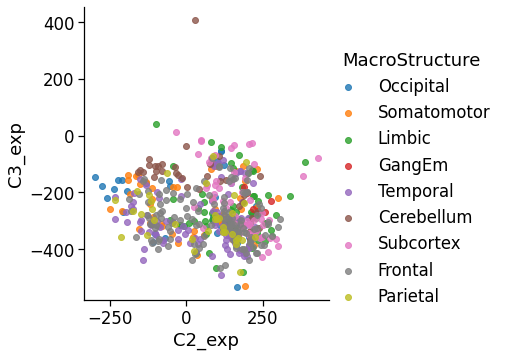

In [39]:
sns.lmplot('C2_exp','C3_exp',data=gdf,#[gdf.new_age_stage=='Adolescent/Adult'],
           hue='MacroStructure',
           fit_reg=False)

# AHBA Comparison

Text(0, 0.5, 'C1 Pattern Expression')

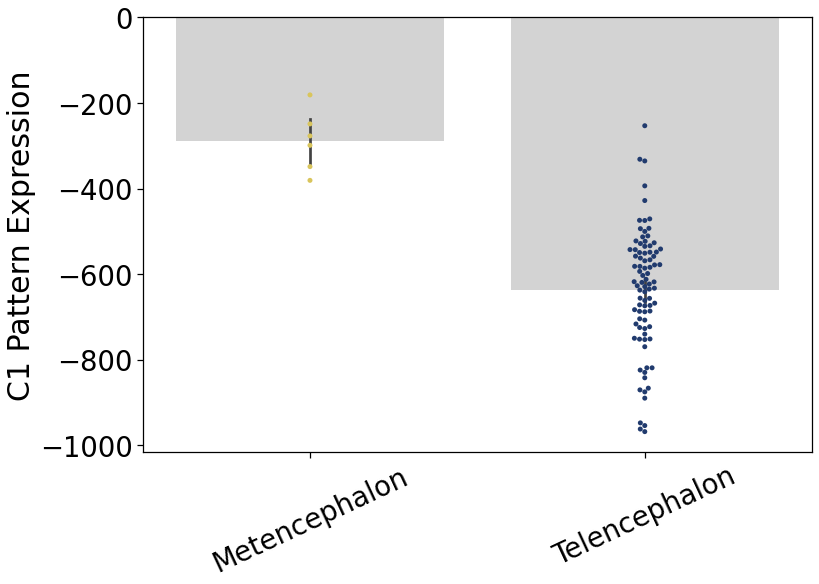

In [29]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Met','Tele']
sns.barplot(x='NT_Segment', y='C1_exp', 
            data=gdf[gdf.Age_Stage=='adult'],
            color='lightgray',
           order = order
           )
g=sns.swarmplot(x='NT_Segment', y='C1_exp', 
              data=gdf[gdf.Age_Stage=='adult'], 
              order = order, palette=rbpal)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Metencephalon','Telencephalon'],rotation=25)
plt.xlabel('')
plt.ylabel('C1 Pattern Expression')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_BS_C1.pdf',
#            bbox_inches='tight')

Text(0, 0.5, 'C3 Pattern Expression')

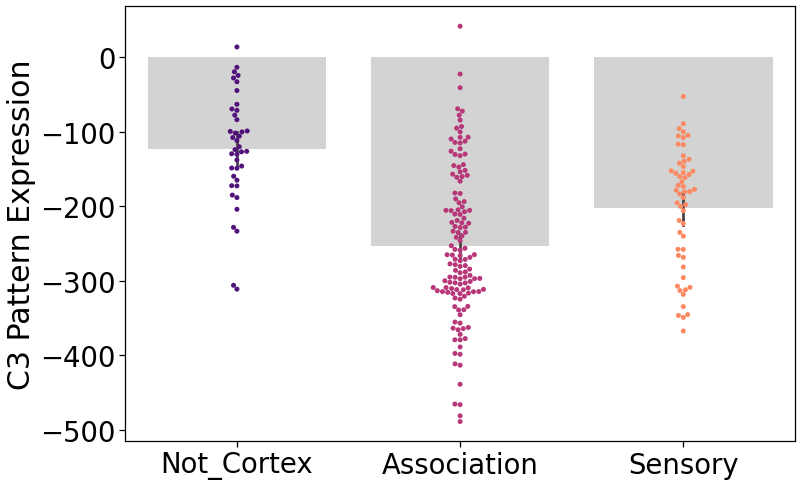

In [30]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not_Cortex','Association','Sensory']
sns.barplot(x='Sensorifugal', y='C3_exp', 
            data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
            color='lightgray',
           order = order
           )
g=sns.swarmplot(x='Sensorifugal', y='C3_exp', 
              data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
              #hue='brain_divison',palette='RdBu'
              order = order, palette='magma'
               )
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#g.set_xticklabels(['Metencephalon','Telencephalon'],rotation=25)
plt.xlabel('')
plt.ylabel('C3 Pattern Expression')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_BS_C3.pdf',
#            bbox_inches='tight')

In [428]:
for c in range(1,4):
    ccol = 'C%s_exp'%c
    nvals = StandardScaler().fit_transform(gdf[ccol].values.reshape(-1,1))[:,0]
    gdf.loc[:,'%s_norm'%ccol] = nvals

In [436]:
expplot = pandas.DataFrame(pandas.concat([gdf.C1_exp_norm,
                                          gdf.C2_exp_norm,
                                          gdf.C3_exp_norm
                                         ]))
expplot.columns = ['expr']
n = len(gdf)
expplot.loc[:,'Component'] = ['1']*n + ['2']*n + ['3']*n
expplot.loc[:,'age_level'] = gdf.age_level.tolist() * 3
expplot.loc[:,'age_in_months'] = gdf.age_in_months.tolist() * 3
expplot.loc[:,'log_age_months'] = gdf.log_age_months.tolist() * 3
expplot.loc[:,'age_in_weeks'] = gdf.age_in_weeks.tolist() * 3
expplot.loc[:,'log_age_weeks'] = gdf.log_age_weeks.tolist() * 3

Text(0.5, 15.439999999999998, 'log Age (weeks)')

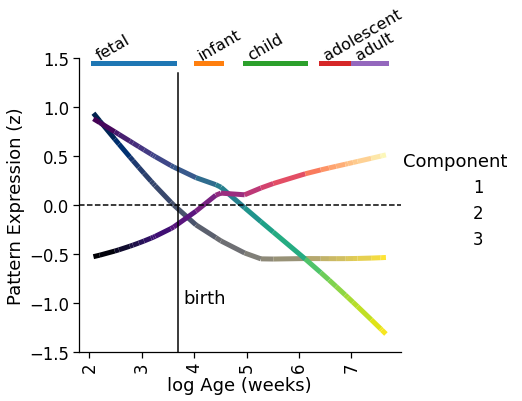

In [438]:
g=sns.lmplot(x='log_age_weeks',y='expr',hue='Component',lowess=True,aspect=1.1,
             hue_order=['1','2','3'],palette='binary',
               data=expplot,scatter_kws={'alpha':0.3},
            markers='')
g.ax.set_ylim(-1.50,1.50)
g.set_xticklabels(rotation=90)
for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.45,1.45],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.45,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,ls='--',c='k')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,-1,'birth')
#plt.ylim(-0.28,1.1)
plt.ylabel('Pattern Expression (z)')
plt.xlabel('log Age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BrSp_CompR_overlay.pdf'),bbox_inches='tight')

# Comparison to adult

In [14]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure2.unique()))
print('missing:',set(gdf.MacroStructure2.unique()) - set(abac2.index))

shared: {'Cerebellum', 'Sensorimotor', 'Occipital', 'Parietal', 'Thalamus', 'Frontal', 'Limbic', 'Temporal', 'Striatum'}
missing: {'GangEm'}


In [15]:
bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure2',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure2==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

In [16]:
c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

BS_mean     BS_sem  ABA_mean   ABA_sem      region
Cerebellum   37.205073  23.029420 -0.242107  0.002839  Cerebellum
Frontal      81.935791  11.113875 -0.137392  0.004650     Frontal
Limbic      148.054347  12.778033  0.090286  0.008034      Limbic
Occipital     7.508905  27.336295 -0.406063  0.006898   Occipital
Parietal     37.597848  23.250301 -0.308702  0.006099    Parietal

Text(14.920000000000002, 0.5, 'C2: BrainSpan')

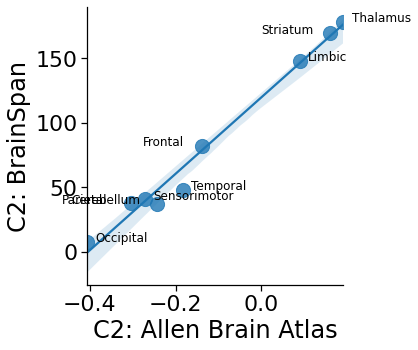

In [31]:
# sns.set_context('notebook',font_scale=2)
# sns.lmplot(x='ABA_mean',y='BS_mean',data=c2_comp,
#            scatter_kws={'marker':'o','s':200}
#           )
# for i,div in enumerate(c2_comp.sort_values('ABA_mean').index):
#     x = c2_comp.loc[div,'ABA_mean']
#     #xsem = c2_comp.loc[div,'ABA_sem']
#     y = c2_comp.loc[div,'BS_mean']
#     #ysem = c2_comp.loc[div,'BS_sem']
#     dist = len(div)*.02
#     if i%2==0:
#         plt.text(x+.02, y,div,{'size':12})
#     else:
#         plt.text(x-dist, y,div,{'size':12},
#                  )
# #     plt.plot([x-xsem,x+xsem],[y,y],c='k')
# #     plt.plot([x,x],[y-ysem,y+ysem],c='k')
# plt.xlabel('C2: Allen Brain Atlas')
# plt.ylabel('C2: BrainSpan')
# # plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_C2.pdf',
# #            bbox_inches='tight')

In [96]:
#gdf.to_csv('/Users/jacobv/Science/PLS_GXP/Brainspan_gdf.csv')

In [19]:
for i in range(1,4):
    vals = StandardScaler().fit_transform(gdf.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    gdf.loc[:,'zC%s_exp'%i,] = vals

In [26]:
pals = ['cividis','viridis','magma']


r = 0.933, p = 0.0


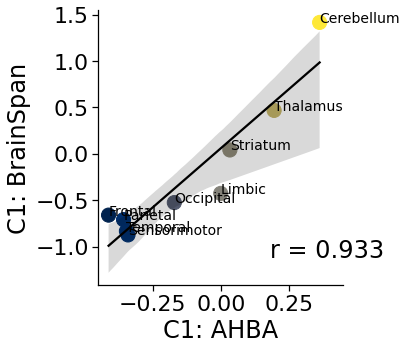

r = 0.975, p = 0.0


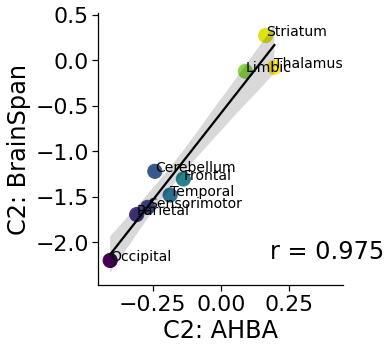

r = 0.854, p = 0.003


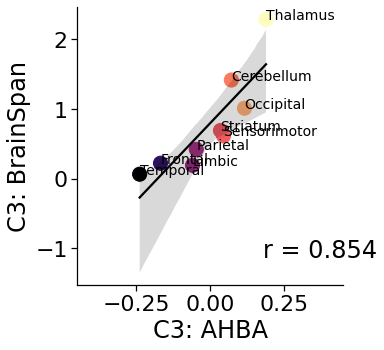

In [458]:
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,4):
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    bs = pandas.pivot_table(#gdf,
                            gdf[gdf.Age_Stage=='adult'],# just the adults!
                          values='zC%s_exp'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['zC%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    g=sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
           #hue='region',legend=False,fit_reg=False
          )
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.BS_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        #xsem = c2_comp.loc[div,'ABA_sem']
        y = comp.loc[div,'BS_mean']
        #ysem = c2_comp.loc[div,'BS_sem']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    #     plt.plot([x-xsem,x+xsem],[y,y],c='k')
    #     plt.plot([x,x],[y-ysem,y+ysem],c='k')
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: BrainSpan'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    plt.xlim(-.45,.45)
    plt.savefig(os.path.join(fig_dir,'BrSp_Repl_C%s.pdf'%i), bbox_inches='tight')
    plt.show()

# Individual subject matching

In [20]:
gpdfs = {}
for i in range(1,4):
    gpdf = gdf[['donor_id','C%s_exp'%i,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='C%s_exp'%i)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [21]:
print(gpdfs[1].shape)
gpdfs[1].head()

(42, 10)


MacroStructure2  Cerebellum     Frontal      Limbic   Occipital    Parietal  \
donor_id                                                                      
12287                   NaN -545.172436         NaN -493.855110 -456.335361   
12288           -399.661932 -492.390176 -438.499461 -449.586169 -525.764310   
12289           -147.928049 -783.805982 -679.350184 -611.712731 -709.495107   
12290           -299.067366 -799.082790 -703.342776 -723.127877 -875.604639   
12295           -245.070779 -574.048062         NaN         NaN         NaN   

MacroStructure2  Sensorimotor    Striatum    Temporal    Thalamus  n_valid  
donor_id                                                                    
12287                     NaN -388.092673 -478.203509 -493.617956      6.0  
12288             -522.928714 -459.299208 -515.985532 -591.163242      9.0  
12289             -747.751473         NaN -793.789026         NaN      7.0  
12290             -824.728064 -598.847106 -838.272756 -617.932096      9.0  
12295                     NaN         NaN         NaN         NaN      2.0

In [37]:
gpdfs[1].n_valid.value_counts()

9.0    18
8.0     9
7.0     6
6.0     3
4.0     2
2.0     2
3.0     1
1.0     1
Name: n_valid, dtype: int64

In [22]:
for c in range(1,4):
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [23]:
cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'new_age_gp', 'new_age_stage','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']

In [24]:
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

r=0.758, p=0.0


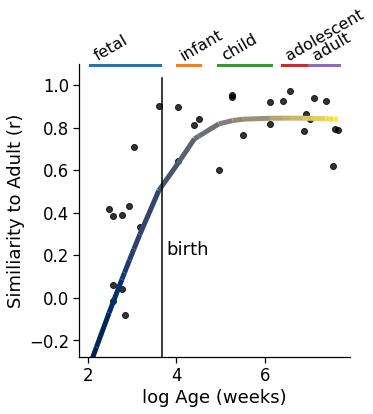

r=0.136, p=0.4301


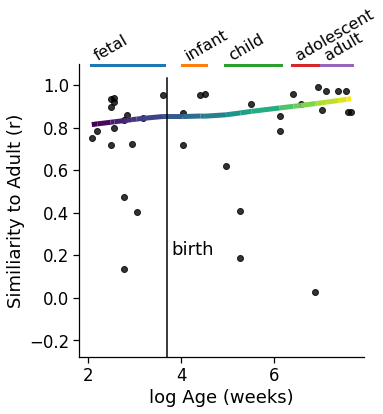

r=0.772, p=0.0


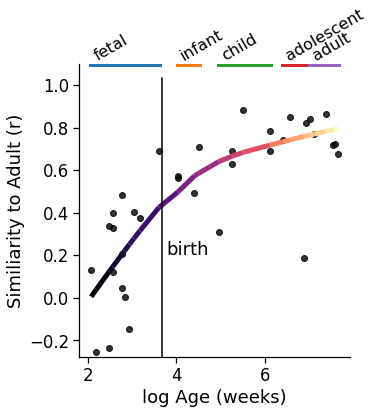

In [27]:
from matplotlib.collections import LineCollection
sns.set_context('notebook',font_scale=1.5)
for c in range(1,4):
    g=sns.lmplot(x='log_age_weeks',y='C%s_r'%c,
                #hue='SEX',
                lowess=True,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'age_level']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
    # make line purty
    x, y = g.ax.get_lines()[0].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    g.ax.get_lines()[0].remove()
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
    
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    plt.ylim(-0.28,1.1)
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.axvline(np.log(40),ymax=0.95,c='k')
    plt.text(np.log(40)+0.1,0.2,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    



In [34]:
devplot = pandas.DataFrame(pandas.concat([subsum.C1_r,
                                          subsum.C2_r,
                                          subsum.C3_r]))
devplot.columns = ['r']
n = len(subsum)
devplot.loc[:,'Component'] = ['1']*n + ['2']*n + ['3']*n
devplot.loc[:,'age_level'] = subsum.age_level.tolist() * 3
devplot.loc[:,'age_stage'] = subsum.Age_Stage.tolist() * 3
devplot.loc[:,'age_in_months'] = subsum.age_in_months.tolist() * 3
devplot.loc[:,'log_age_months'] = subsum.log_age_months.tolist() * 3
devplot.loc[:,'age_in_weeks'] = subsum.age_in_weeks.tolist() * 3
devplot.loc[:,'log_age_weeks'] = subsum.log_age_weeks.tolist() * 3

Text(0.5, 15.439999999999998, 'log Age (weeks)')

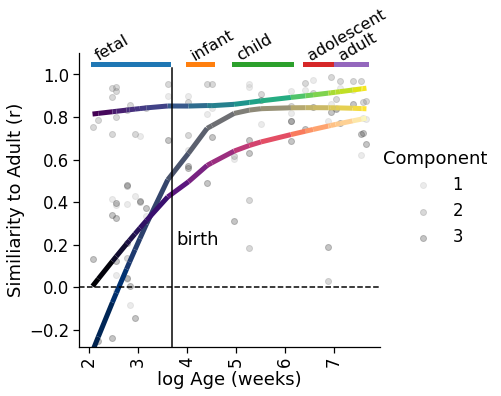

In [29]:
g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1.1,
             hue_order=['1','2','3'],palette='binary',
               data=devplot,scatter_kws={'alpha':0.3})
g.ax.set_ylim(-0.3,1.08)
g.set_xticklabels(rotation=90)
for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,ls='--',c='k')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.2,'birth')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BrSp_CompR_overlay.pdf'),bbox_inches='tight')

# Comparison to GTex
Note: The GTEx notebook should be run before proceeding to this part

In [46]:
# CHANGE TO data/
gss = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GTEx_IndivCongruence.csv',
                     index_col=0)

In [47]:
# Need to change these paths as well
basedf = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_brain_norm_noregress_meta.csv')
excludf = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GTEx/GTEx_meta.csv',index_col=0)
dx_exclude = list(set(basedf.SUBJID.values) - set(excludf.SUBJID.values))
gss.loc[gss.SUBJID.isin(dx_exclude),'Excl_Dx'] = 1
gss.loc[gss.Excl_Dx!=1,'Excl_Dx'] = 0

In [48]:
d1 = pandas.DataFrame(gss[['AGE','SEX','C1_r','C2_r','C3_r','n_valid','Excl_Dx']],
                      copy=True)
d1.columns = ['age','sex','C1_r','C2_r','C3_r','nvalid','Excl_Dx']
d1.loc[:,'cohort'] = 'GTEx'
d1.loc[:,'age_in_months'] = (d1.loc[:,'age'] * 12)+9
d1.loc[:,'age_in_weeks'] = (d1.loc[:,'age'] * 52)+40

d2 = pandas.DataFrame(subsum[['age','gender','C1_r','C2_r',
                              'C3_r','n_valid','age_in_months','age_in_weeks']],
                     copy=True)
d2.columns = ['age','sex','C1_r','C2_r','C3_r','nvalid','age_in_months','age_in_weeks']
d2.loc[:,'cohort'] = 'BrainSpan'

dsmerge = pandas.concat([d1,d2])

In [56]:
dsmerge.loc[:,'logAge'] = np.log(dsmerge.loc[:,'age_in_weeks'].values)

In [57]:
dsmerge.loc[:,'old_ind'] = dsmerge.index
dsmerge.index = range(len(dsmerge))

In [495]:
gxp.shape

(13750, 524)

In [58]:
for i,row in dsmerge.iterrows():
    age = row['age_in_months'] / 12
    if age < 0.72:
        decade = 0
    elif age < 2:
        decade = 0.1
    elif age < 9:
        decade = 0.5
    else:
        decade = round(age/10)
    dsmerge.loc[i,'decade'] = decade

In [59]:
ages = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].logAge.tolist() * 3)
rs = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].C1_r.tolist() +\
                   dsmerge[dsmerge.cohort=='GTEx'].C2_r.tolist() +\
                   dsmerge[dsmerge.cohort=='GTEx'].C3_r.tolist())
n = len(dsmerge[dsmerge.cohort=='GTEx'])
comp = pandas.Series(['C1']*n + ['C2']*n + ['C3']*n)
decade = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].decade.tolist() * 3)
excl = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].Excl_Dx.tolist() * 3)
gtplotr = pandas.concat([ages,rs,comp,decade,excl],axis=1)
gtplotr.columns = ['logAge','r','component','decade','excl_dx']


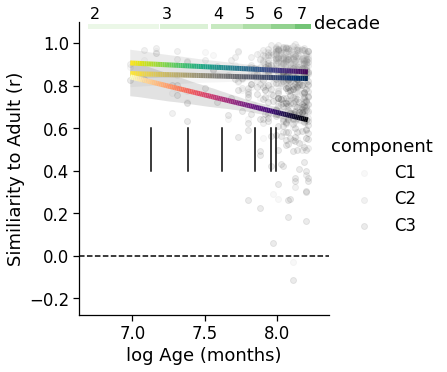

In [60]:
sns.set_context('notebook',font_scale=1.5)
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
g=sns.lmplot(x='logAge',y='r',hue='component',data=gtplotr,
          scatter_kws={'alpha':0.1},palette='binary')
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (months)')

for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap='%s_r'%pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for i,dec in enumerate(sorted(gtplotr.decade.unique())):
    if dec == 8: continue
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(xmax+0.5,1.05,'decade',ha='right',va='bottom')
allen_ages = [57,31,49,55,24,39]
for aa in allen_ages:
    la = np.log((aa*52))
    plt.plot([la,la],[0.4,0.6],c='k')
plt.savefig(os.path.join(fig_dir,'GTEx_logAge.pdf'),bbox_inches='tight')

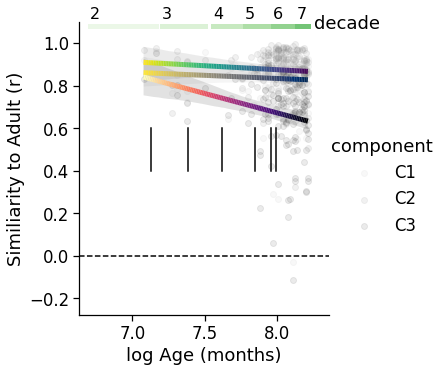

In [61]:
# now repeat after excluding all people who died with a brain-related clinical diagnosis
sns.set_context('notebook',font_scale=1.5)
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
g=sns.lmplot(x='logAge',y='r',hue='component',data=gtplotr[gtplotr.excl_dx==0],
          scatter_kws={'alpha':0.1},palette='binary')
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (months)')

for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap='%s_r'%pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for i,dec in enumerate(sorted(gtplotr.decade.unique())):
    if dec == 8: continue
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(xmax+0.5,1.05,'decade',ha='right',va='bottom')
allen_ages = [57,31,49,55,24,39]
for aa in allen_ages:
    la = np.log((aa*52))
    plt.plot([la,la],[0.4,0.6],c='k')
plt.savefig(os.path.join(fig_dir,'GTEx_logAge_ctrl.pdf'),bbox_inches='tight')

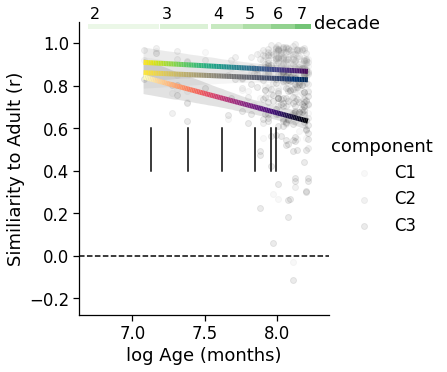

In [62]:
# now repeat after excluding all people who died with a brain-related clinical diagnosis
sns.set_context('notebook',font_scale=1.5)
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
g=sns.lmplot(x='logAge',y='r',hue='component',data=gtplotr[gtplotr.excl_dx==0],
          scatter_kws={'alpha':0.1},palette='binary')
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (months)')

for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap='%s_r'%pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for i,dec in enumerate(sorted(gtplotr.decade.unique())):
    if dec == 8: continue
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(xmax+0.5,1.05,'decade',ha='right',va='bottom')
allen_ages = [57,31,49,55,24,39]
for aa in allen_ages:
    la = np.log((aa*52))
    plt.plot([la,la],[0.4,0.6],c='k')
plt.savefig(os.path.join(fig_dir,'GTEx_logAge_ctrl.pdf'),bbox_inches='tight')

In [63]:
dsmerge.to_csv('BrainSpan_GTEx_PLSC_similarity.csv')

# Gene Tracking Take 2

In [119]:
from sklearn.preprocessing import StandardScaler

perc = 0.025 / 3
thresh = int(round(c1.shape[0] * 0.025))
plotr = pandas.DataFrame(gxp.reindex(c1.gene_symbol
                                    ).dropna().iloc[-thresh:],
                         copy=True).T
gcols = plotr.columns
plotr = pandas.DataFrame(StandardScaler().fit_transform(plotr.values),
                 index=plotr.index,columns=gcols)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period','new_age_stage',
            'age_in_months','donor_id']:
    plotr.loc[:,col] = gdf.loc[:,col].values

gmtx1 = pandas.DataFrame(np.zeros((len(gcols),
                                   len(gdf.new_age_stage.unique()))),
                         index=gcols,
                       columns = gdf.new_age_stage.unique())
for stage in gdf.new_age_stage.unique():
    gmtx1.loc[:,stage] = plotr[plotr.new_age_stage==stage][gcols].mean(0).values

In [135]:
cmat = np.corrcoef(plotr[plotr.columns[:thresh]].T)

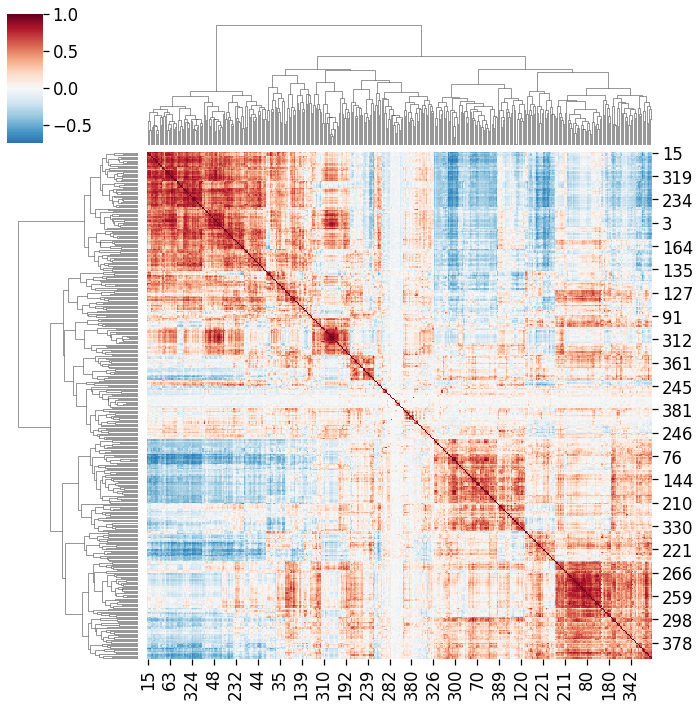

In [144]:
sns.clustermap(cmat,cmap='RdBu_r',center=0)

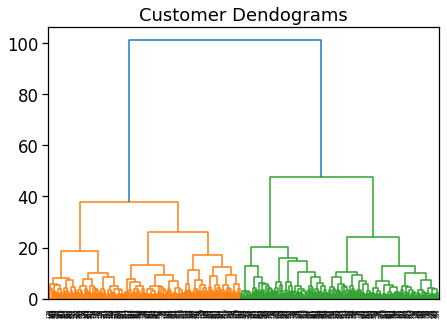

In [138]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(7, 5))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(cmat, method='ward'))

<AxesSubplot:>

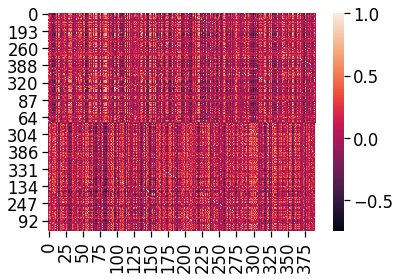

In [143]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(cmat)
data = pandas.DataFrame(cmat,copy=True)
data.loc[:,'labels'] = cluster.labels_
sns.heatmap(data.sort_values('labels'))#[data.columns[:3]])

# GMatching 3

In [153]:
gxp.T.head()

TSPAN6       DPM1     SCYL3  C1orf112       FGR       CFH      FUCA2  \
0  36.447128  34.373239  4.379337  3.957119  0.244174  1.739810  10.093235   
1  24.251253  20.765661  4.227521  3.520794  0.266976  1.631157   7.413745   
2  19.330479  18.734947  2.551825  2.037805  0.248188  1.505638   6.844418   
3  27.668607  22.366394  3.603764  3.487035  0.141398  0.184312   8.241343   
4  19.998231  19.228431  2.948976  2.177235  0.467688  8.457812   8.193750   

       GCLC       NFYA    NIPAL3  ...     KRT86      MC1R      CEP95  \
0  2.632164  24.845660  1.363100  ...  0.000000  0.821452   7.177763   
1  2.350074  27.283269  1.368581  ...  0.000000  1.098753  11.569297   
2  2.091245  26.226790  3.363718  ...  0.037396  1.293542   5.527288   
3  1.970610  26.843769  1.954944  ...  0.007008  1.636771   7.484177   
4  2.780556  29.272971  2.076517  ...  0.018765  1.012451   5.848950   

    CXADRP2   TMEM179   SLC35G6       GH1      THTPA   ANP32AP1      BLID  
0  1.634086  1.296794  0.030182  0.000000  10.625217  41.935201  0.000000  
1  1.692605  1.838100  0.000000  0.000000   9.690860  52.451933  0.000000  
2  4.116266  4.517416  0.000000  0.000000  11.201571  35.506476  0.051061  
3  1.817248  3.320381  0.000000  0.080715  12.094830  35.755697  0.000000  
4  3.123316  2.227969  0.000000  0.000000  10.376242  38.726738  0.000000  

[5 rows x 13750 columns]

In [156]:
c = 2

jnk = pandas.DataFrame(gxp.T,copy=True)
for col in ['donor_id','MacroStructure2','C%s_exp'%c]:
    jnk.loc[:,col] = gdf[col].values

In [162]:
gene = gxp.index[0]
jnk[['donor_id',gene,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values=gene)

MacroStructure2  Cerebellum    Frontal     GangEm     Limbic  Occipital  \
donor_id                                                                  
12287                   NaN   8.890583        NaN        NaN   7.556875   
12288             30.968277  10.914580        NaN  28.969870  11.506450   
12289              1.435841   3.154763        NaN   7.564598   2.016692   
12290              0.895193   1.970702        NaN   3.460282   0.951947   
12295              8.540184  12.413859        NaN        NaN        NaN   
12296             12.405425   5.517724        NaN   7.501840   2.905960   
12298              6.302412   5.177695        NaN   7.406366        NaN   
12299              1.696964        NaN        NaN   4.259458        NaN   
12300              2.606941   2.893015        NaN   6.612684        NaN   
12302              1.596372   1.997373        NaN   8.521009   1.888270   
12303              2.939096   2.359342        NaN   3.761476   1.941080   
12304              1.781548   2.532635        NaN   4.917775   2.277359   
12365             15.799245        NaN        NaN        NaN        NaN   
12820                   NaN  10.412593        NaN  18.371493   5.111040   
12830              3.157639   3.251742        NaN   9.051072   2.972877   
12831              2.583531   2.817948        NaN   5.595322   2.957646   
12832              1.650722   2.488469        NaN   3.543803   1.052040   
12833             13.984353  23.635457  23.142003  26.675872  19.211090   
12834             15.653765   8.081635        NaN  16.506628   5.164254   
12835                   NaN   6.670467        NaN  27.038769   3.490831   
12836              1.055821  11.410221        NaN   6.466928   5.667535   
12837             39.422124   8.253780        NaN  14.133367   8.454797   
12841              4.679973   7.706523        NaN   6.266943   8.447940   
12879                   NaN  13.410308        NaN  17.795257  12.024979   
12880             19.666858   8.023384        NaN  11.223719   6.850831   
12885                   NaN   7.518396        NaN  19.302133   3.426339   
12886             24.262471   7.332366        NaN  10.984883   4.162621   
12888             12.835930  12.112336        NaN  18.089285   6.355281   
12889                   NaN  14.100508        NaN  16.489710        NaN   
12890              5.190141   6.112156        NaN  14.384293   4.088404   
12948                   NaN        NaN        NaN        NaN        NaN   
12949                   NaN   6.544657        NaN        NaN   5.103003   
12960             18.416845   6.235365        NaN  21.781135   3.958576   
12977              1.370941   4.216455        NaN        NaN   3.135840   
12979              2.385179   3.071063        NaN   7.175937   2.163914   
12980              1.440123   4.970364        NaN   6.465879   5.102979   
12981              1.856414   3.722573        NaN   6.764237   2.313554   
12984              1.768393   4.937041        NaN   5.870341   5.151395   
13057              1.652139   2.762312        NaN   4.884139   2.059929   
13058             14.680673  40.187453  25.798194  31.262321  36.447128   
13060             17.379804   9.733822        NaN  19.373494   4.990750   
263195015         25.148719  12.872485        NaN  23.328322  10.825351   

MacroStructure2   Parietal  Sensorimotor   Striatum   Temporal   Thalamus  
donor_id                                                                   
12287             7.111051           NaN   5.583153   7.317786  10.148624  
12288             7.710396      9.663042  13.663251   7.327519  15.380457  
12289             3.500082      3.274518        NaN   5.122772        NaN  
12290             1.558910      1.634866   3.006085   1.538251   1.361271  
12295                  NaN           NaN        NaN        NaN        NaN  
12296                  NaN           NaN   3.325266   6.490407   4.249478  
12298                  NaN           NaN   6.313185   7.684669   7.689562  
12299          

In [281]:
c2.loc[:,'abs_expr'] = abs(c2.expr.round(6).values)
perc = 0.05 / 3
thresh = int(round(c2.shape[0] * perc))
genes = c2.sort_values('abs_expr').dropna().gene_symbol.iloc[-thresh:].index

In [283]:
genes

Index(['PDLIM3', 'MAOB', 'PPP2R5A', 'DNAJA4', 'PCBP3', 'MYO19', 'MEI1', 'TFAM',
       'DNALI1', 'CAMK1D',
       ...
       'CPLX2', 'LXN', 'HCN4', 'SYT10', 'MGP', 'AMDHD1', 'TDRD1', 'TGFBI',
       'MET', 'PRRX1'],
      dtype='object', length=261)

In [241]:
c = 2

jnk = pandas.DataFrame(gxp.T,copy=True)
for col in ['donor_id','MacroStructure2','C%s_exp'%c]:
    jnk.loc[:,col] = gdf[col].values
    
aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
               index_col=0)
aba.columns = ['ABA_mean','ABA_sem']

subsum = pandas.DataFrame(index=gdf.donor_id.unique())
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values

for it,gene in enumerate(gxp.index):
    if it == 100:
        print('first 100')
    if it % 1000 == 0:
        print('working on %s of %s'%((it+1),len(gxp)))
    gpdf = jnk[['donor_id',gene,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values=gene)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    for i,row in gpdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    subsum.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

working on 1 of 13750
first 100


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 1001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 2001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 3001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 4001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 5001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 6001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

working on 7001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 8001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 9001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 10001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 11001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 12001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

working on 13001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


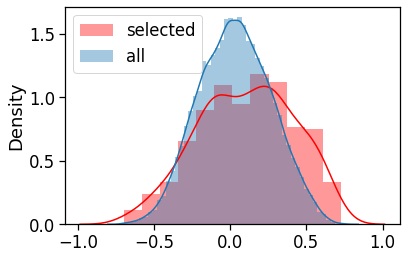

In [264]:
selected = subsum[['%s_r'%x for x in genes if x in gxp.index]].mean()
allrs = subsum[[x for x in subsum.columns if '_r' in x]].mean()
sns.distplot(selected,label='selected',color='red')
sns.distplot(allrs,label='all')
plt.legend()

In [272]:
# for x in [x.split('_r')[0] for x in sig]:
#     print(x)

In [269]:
sig = []
thr = round(len(allrs)*0.025)
cil = allrs.sort_values().values[thr]
ciu = allrs.sort_values().values[-thr]
print('CI:',cil,ciu)
for x in selected.index:
    if selected[x] >= ciu or selected[x] <= cil:
        sig.append(x)
print('# significant:',len(sig))
print(sig)

CI: -0.41448412698412695 0.49530872366139334
# significant: 69
['MT1E_r', 'APLN_r', 'MBP_r', 'MSRB2_r', 'NDRG3_r', 'MICAL2_r', 'CNKSR2_r', 'LIMS2_r', 'KLF13_r', 'WDR78_r', 'SLN_r', 'CPXM2_r', 'LDHD_r', 'NR2F2_r', 'FANK1_r', 'TPPP3_r', 'RBP1_r', 'ID4_r', 'BEND6_r', 'MAOB_r', 'DNALI1_r', 'VAT1_r', 'HES5_r', 'BAIAP3_r', 'EIF4E1B_r', 'HEYL_r', 'TRPS1_r', 'TSPAN1_r', 'UBE2QL1_r', 'ATP2B2_r', 'RSPO4_r', 'PLEKHM2_r', 'CCDC103_r', 'CABP1_r', 'GFAP_r', 'NKAIN4_r', 'SCN7A_r', 'SGSH_r', 'SLC26A11_r', 'BID_r', 'NFIC_r', 'CHODL_r', 'PCBD1_r', 'FAM13A_r', 'SEMA7A_r', 'TBR1_r', 'DBX2_r', 'RASL12_r', 'WDR66_r', 'ATP2B3_r', 'ISLR_r', 'CXorf57_r', 'LY6D_r', 'GPR143_r', 'AQP1_r', 'FERMT1_r', 'RGS22_r', 'ST3GAL6_r', 'LRRC36_r', 'SCN9A_r', 'KLHL13_r', 'LRRN1_r', 'VWA5A_r', 'SIX3_r', 'COX7A1_r', 'HSPB8_r', 'KCNA5_r', 'ZMYND10_r', 'CPLX2_r']


In [275]:
subsum.columns[:20]

Index(['column_num', 'donor_id', 'donor_name', 'age', 'gender', 'structure_id',
       'structure_acronym', 'structure_name', 'Age_Stage', 'Age_Epoch',
       'Age_Period', 'MacroStructure', 'MacroStructure2', 'NT_Segment',
       'Sensorifugal', 'age_level', 'new_age_gp', 'new_age_stage',
       'age_in_months', 'log_age_months'],
      dtype='object')

In [ ]:
vis_pass = ['MBP','LIMS2','WDR78','LDHD','TPP3','ID4','MAOB',
           'HES5','TRPS1','CAPB1','DBX2','RASL12','FERMT1',
           'SCN9A','KLHL13','VWA54']

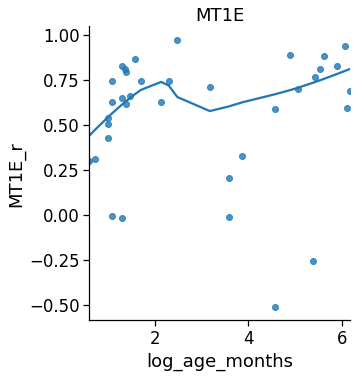

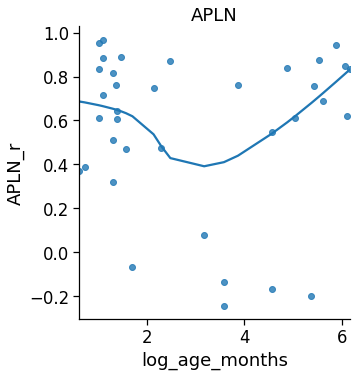

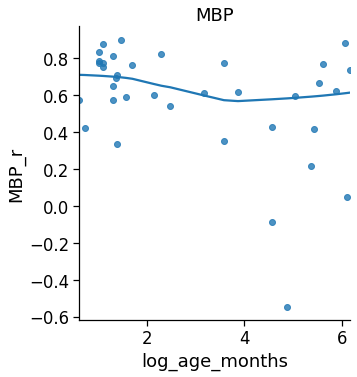

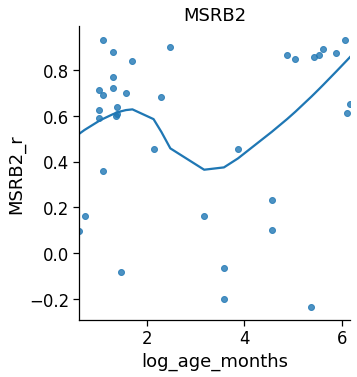

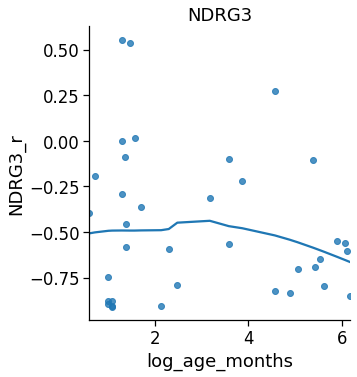

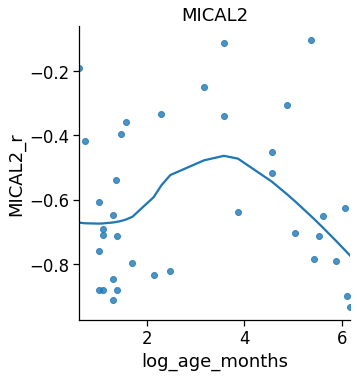

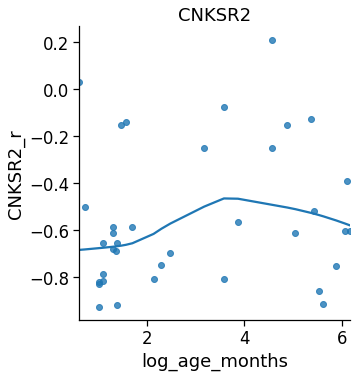

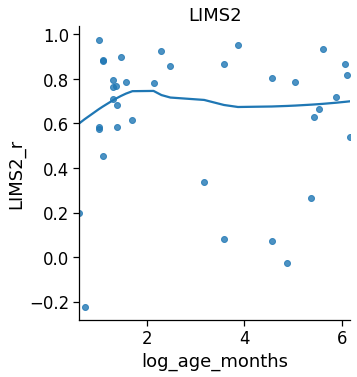

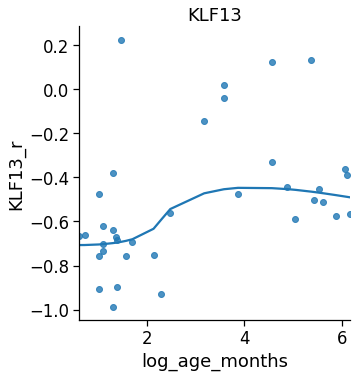

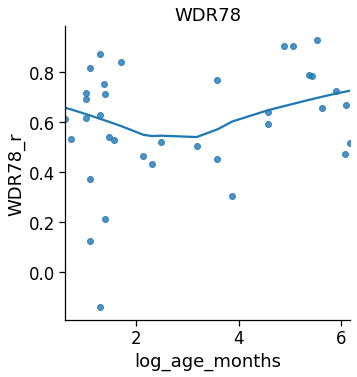

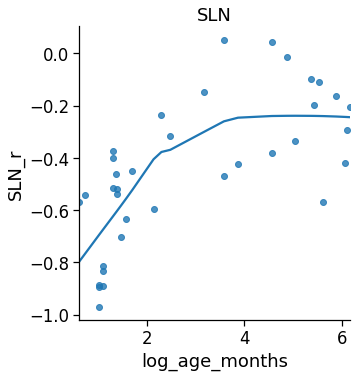

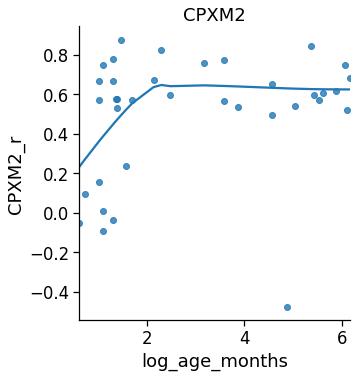

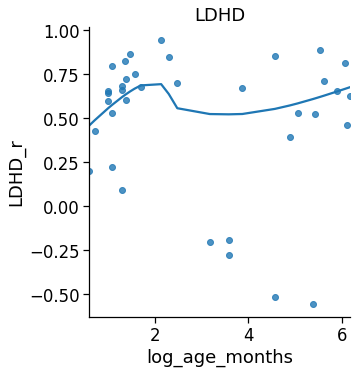

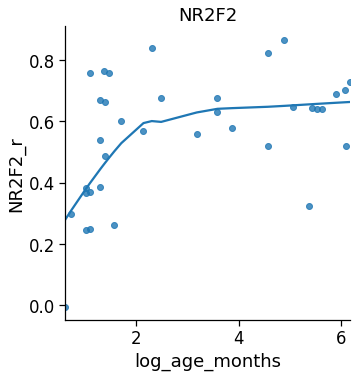

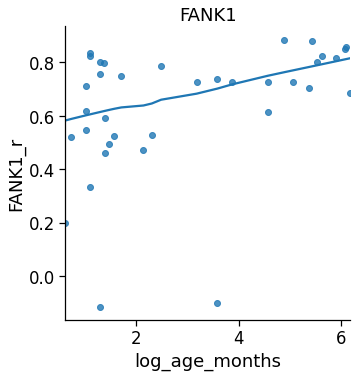

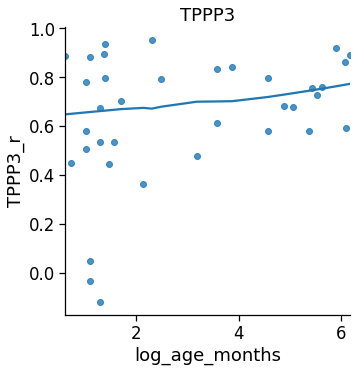

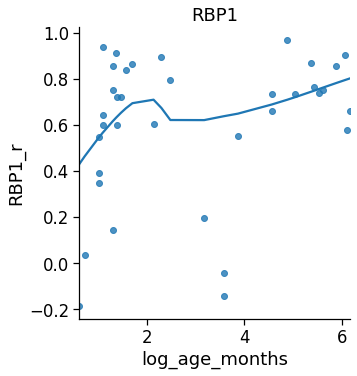

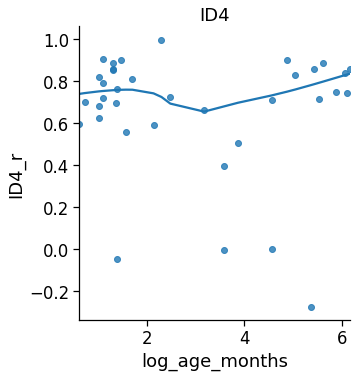

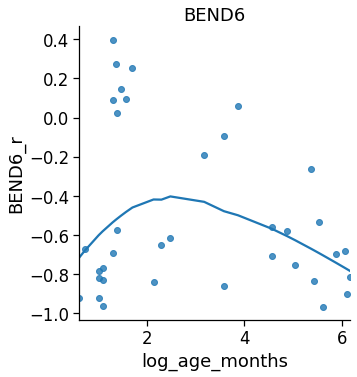

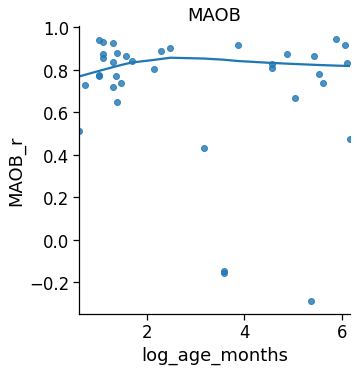

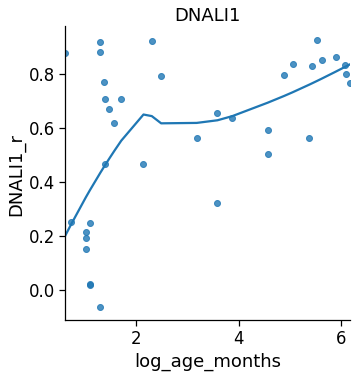

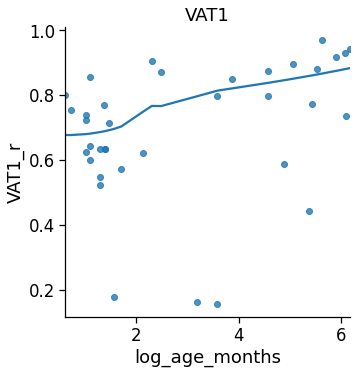

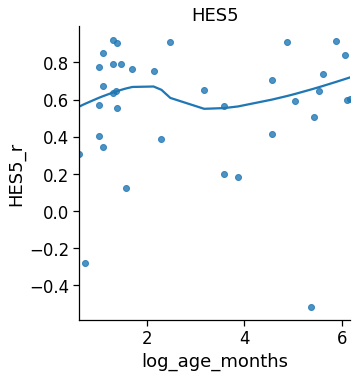

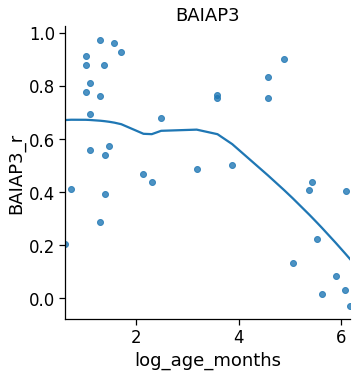

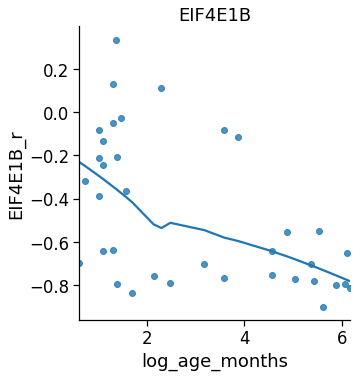

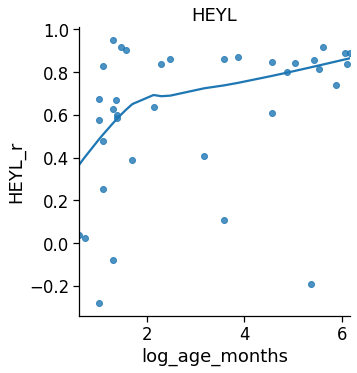

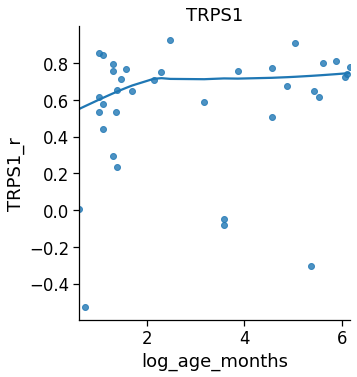

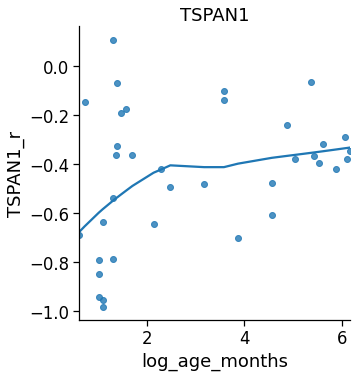

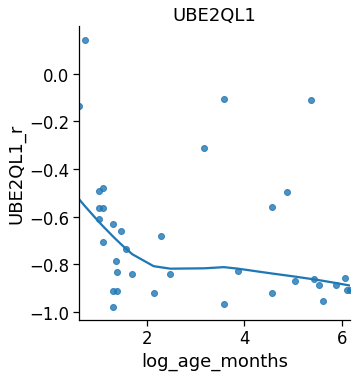

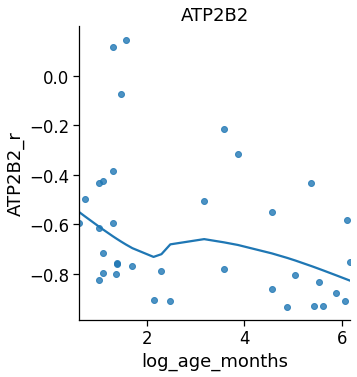

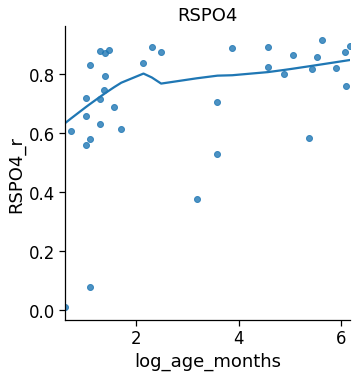

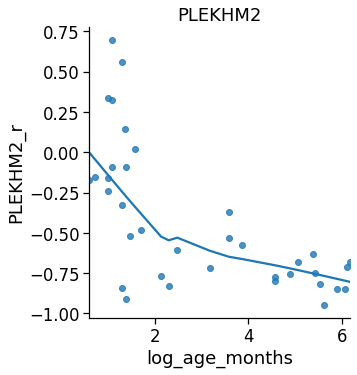

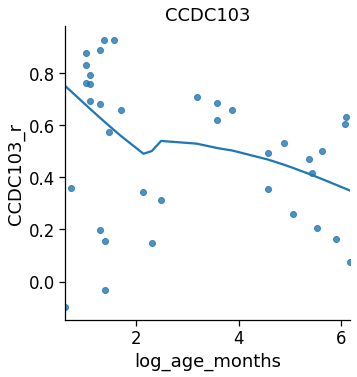

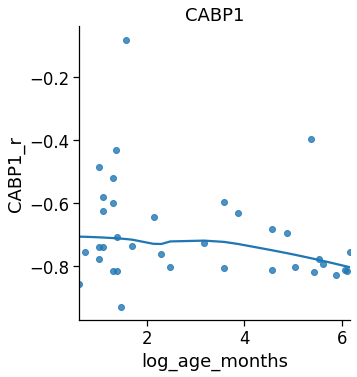

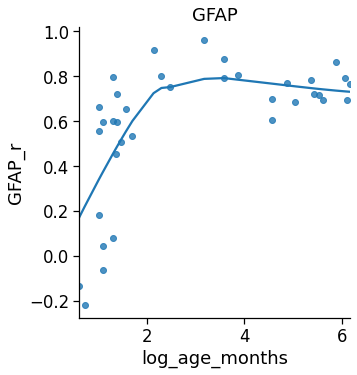

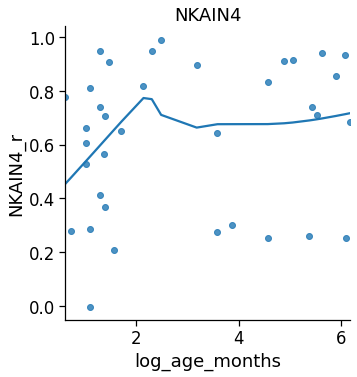

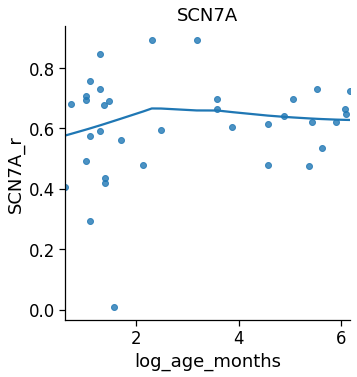

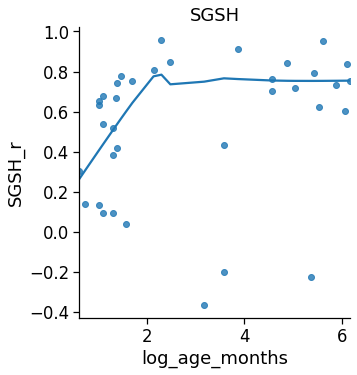

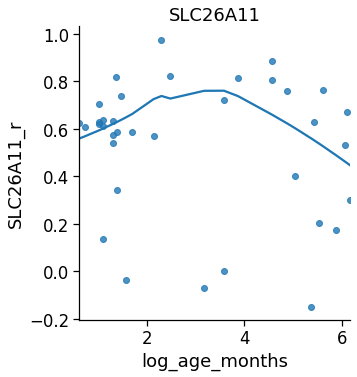

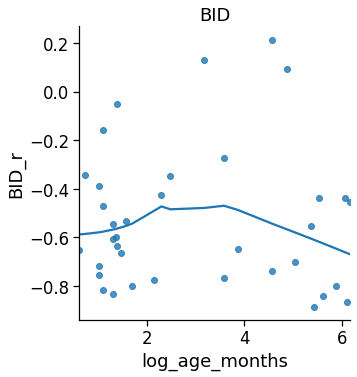

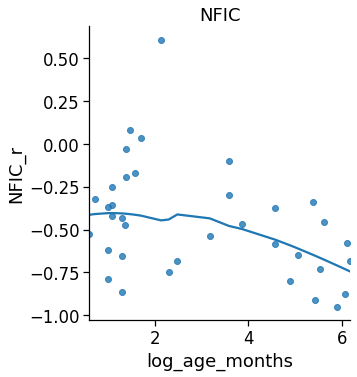

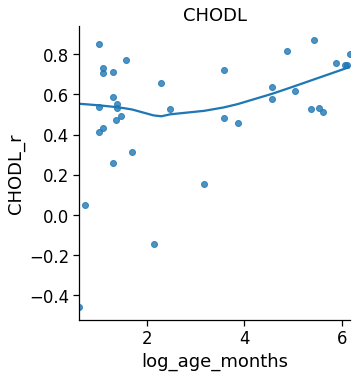

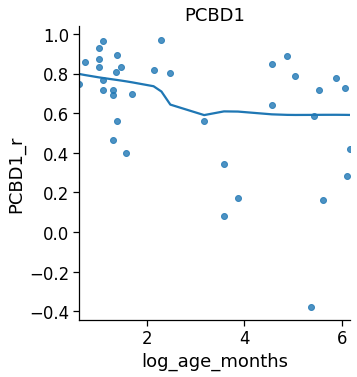

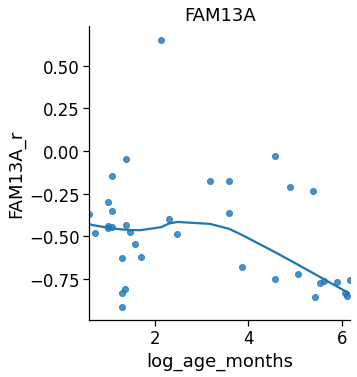

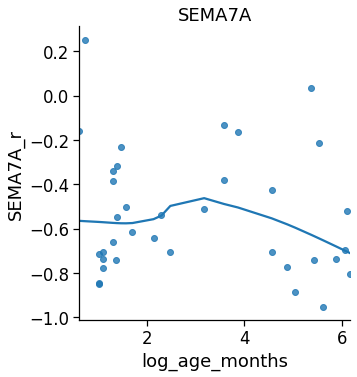

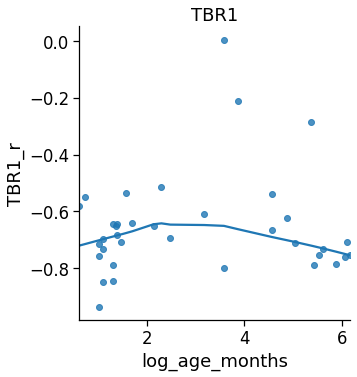

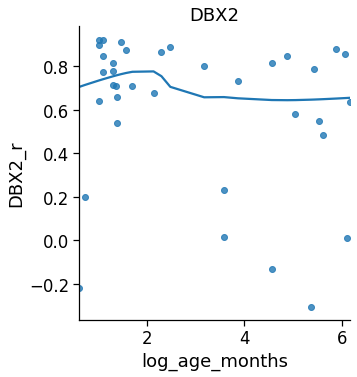

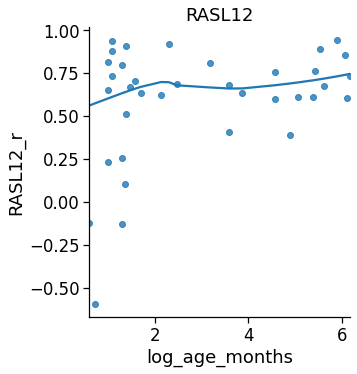

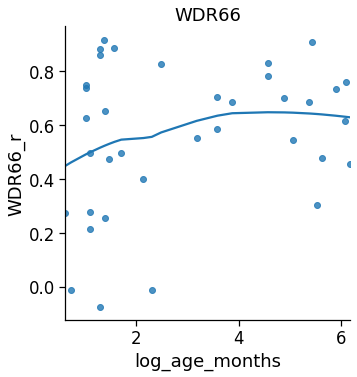

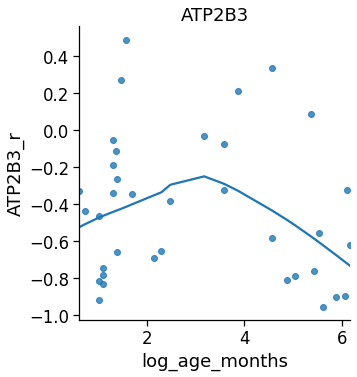

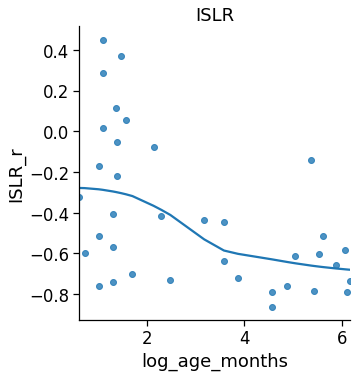

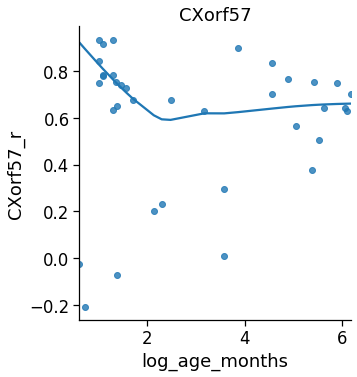

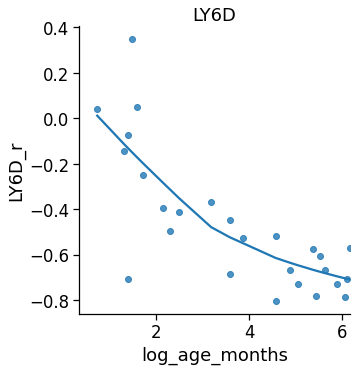

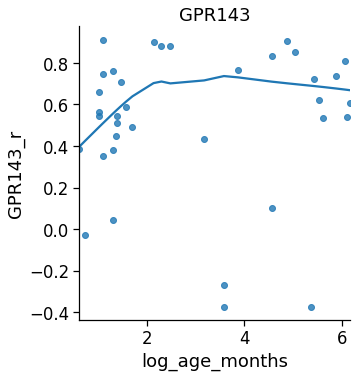

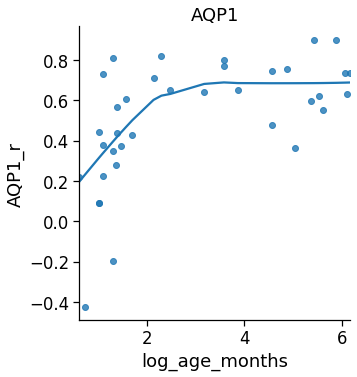

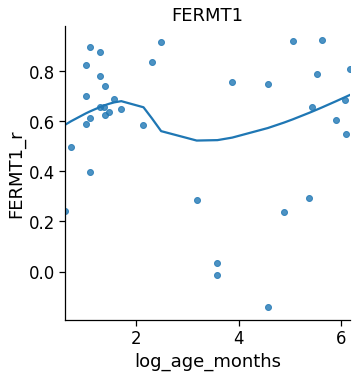

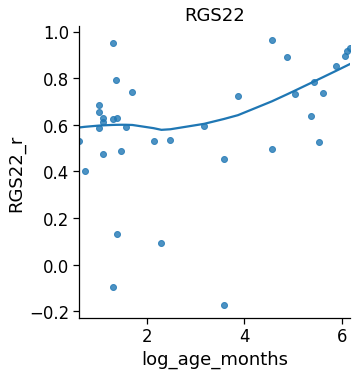

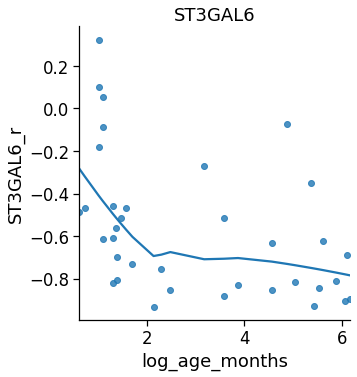

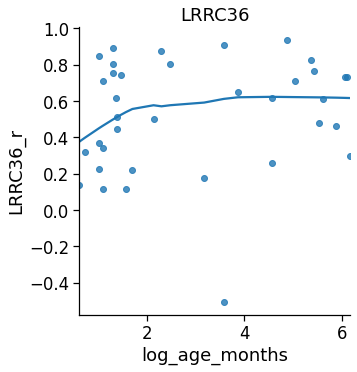

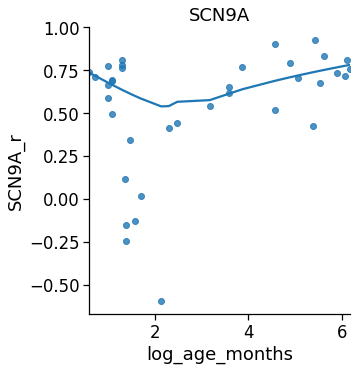

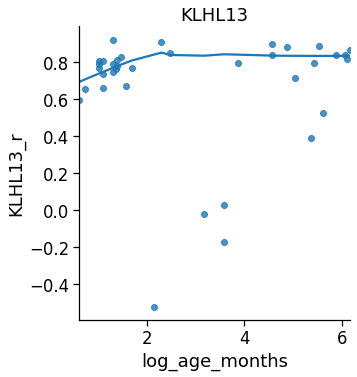

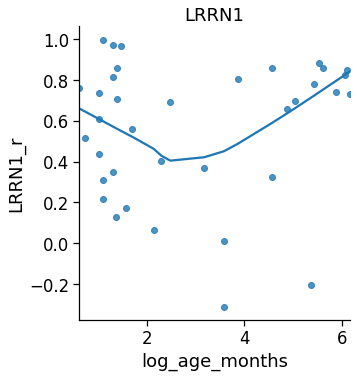

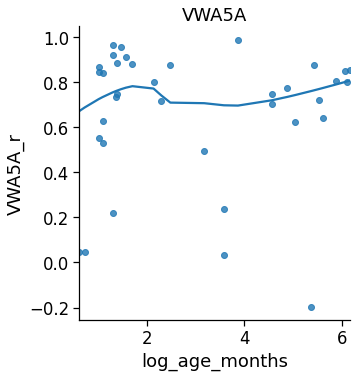

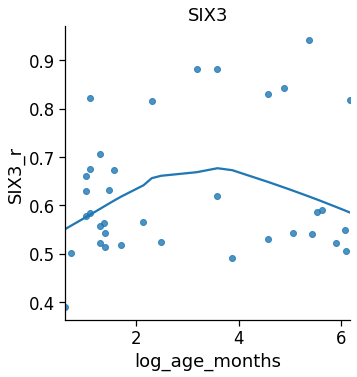

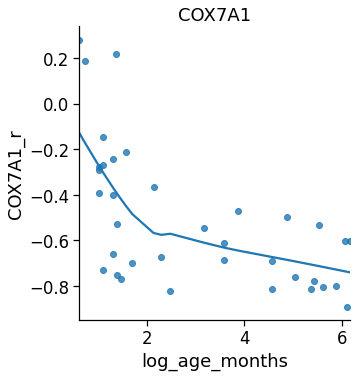

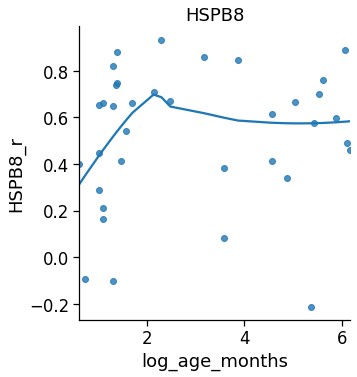

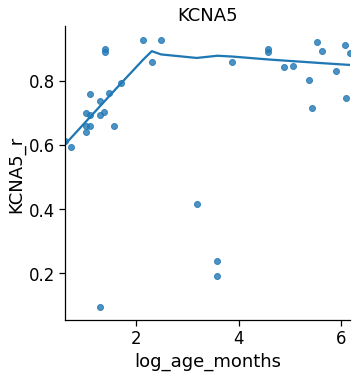

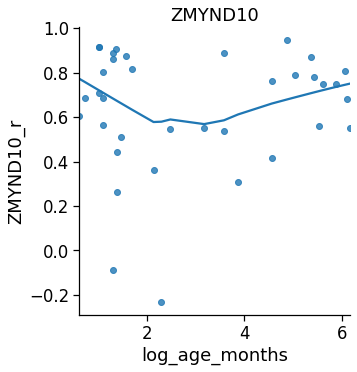

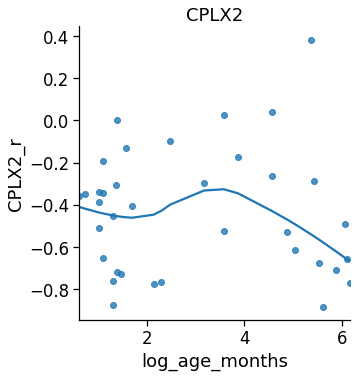

In [279]:
for gene in sig:
    g=sns.lmplot(x='log_age_months',y=gene,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=subsum)
    plt.title(gene.split('_')[0])
    plt.show()

In [323]:
c2ss = pandas.DataFrame(subsum[[x for x in subsum.columns[20:] if x[-2:] == '_r' and \
                                                        x.split('_')[0] in genes]],
                       copy=True)
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

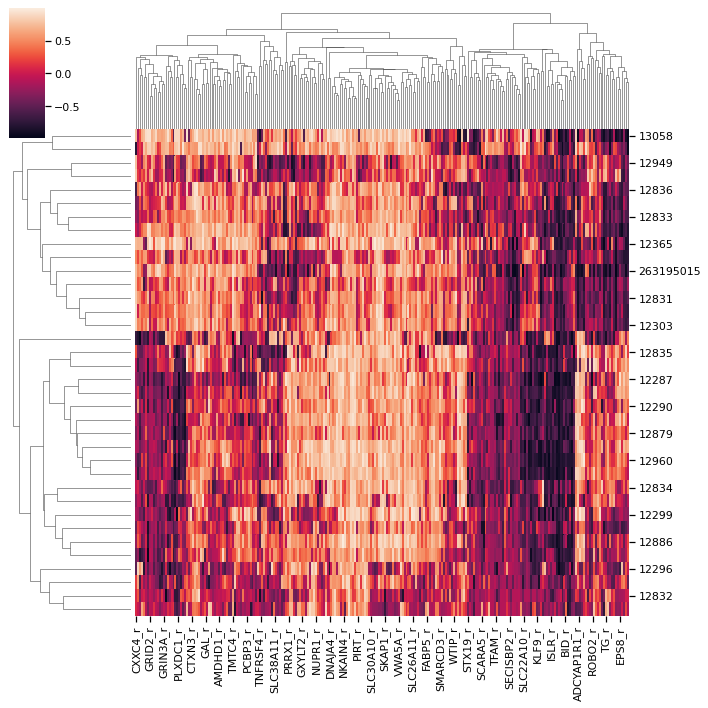

In [324]:
sns.set_context('notebook',font_scale=1)
g = sns.clustermap(c2ss)

In [ ]:
subsum.loc[g.data2d.index]['age']

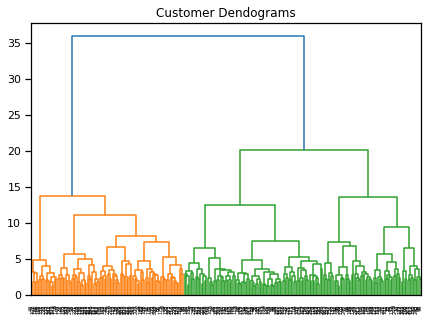

In [331]:
plt.figure(figsize=(7, 5))
plt.title("Customer Dendograms")
link = shc.linkage(c2ss.T.values, method='ward')
dend = shc.dendrogram(link)

<AxesSubplot:>

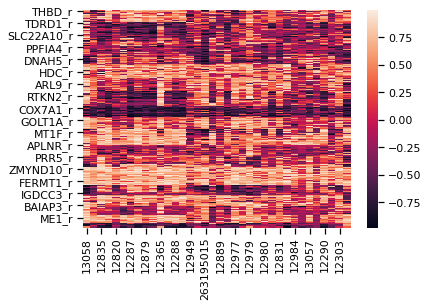

In [347]:
cluster = AgglomerativeClustering(n_clusters=24, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sns.heatmap(data.sort_values('labels')[data.columns[:-1]])

In [348]:
cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

cluster0  cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  \
13058  0.402006  0.382295  0.088673  0.081616 -0.546243  0.357291  0.683844   
12833 -0.116456 -0.278845  0.203976 -0.287574 -0.276285  0.331040  0.451449   
12835  0.069493 -0.404290 -0.528590 -0.184500  0.436256  0.246756 -0.077055   
12960  0.668138 -0.533549 -0.249643 -0.327094  0.262794  0.561039  0.123437   
12820  0.054199 -0.307051  0.228470 -0.182537 -0.308151  0.374700  0.322129   

       cluster7  cluster8  cluster9  ...  Age_Period  MacroStructure  \
13058  0.541460  0.514636 -0.538925  ...          p4         Frontal   
12833  0.412041  0.028624 -0.672353  ...          p6          Limbic   
12835 -0.431808 -0.064022 -0.564562  ...         p11         Frontal   
12960 -0.665465 -0.294235 -0.804330  ...         p12        Temporal   
12820 -0.363798 -0.241661 -0.455131  ...          p8        Temporal   

       MacroStructure2  NT_Segment  Sensorifugal  age_level        new_age_gp  \
13058          Frontal        Tele   Association          4    Early_Prenatal   
12833           Limbic        Tele   Association          8  Adolescent/Adult   
12835          Frontal        Tele   Association         20         Perinatal   
12960         Temporal        Tele   Association         27         Perinatal   
12820         Temporal        Tele   Association         13             Child   

          new_age_stage  age_in_months  log_age_months  
13058             fetal       3.678161        1.302413  
12833             fetal       5.517241        1.707878  
12835  Adolescent/Adult     132.000000        4.882802  
12960  Adolescent/Adult     360.000000        5.886104  
12820      Infant/Child       4.000000        1.386294  

[5 rows x 44 columns]

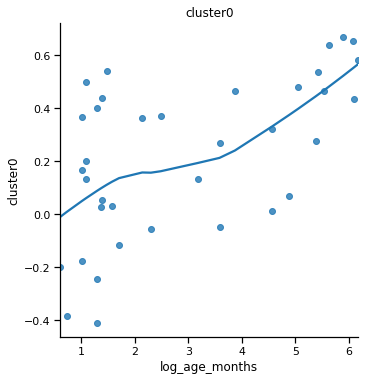

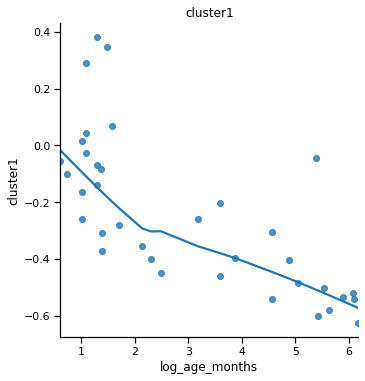

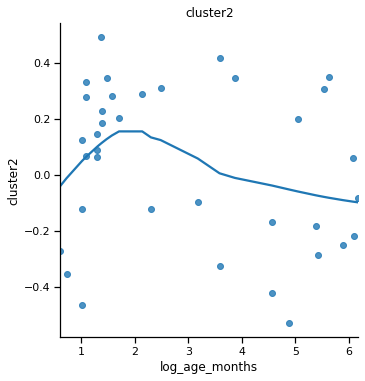

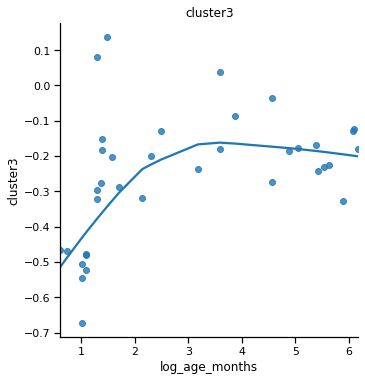

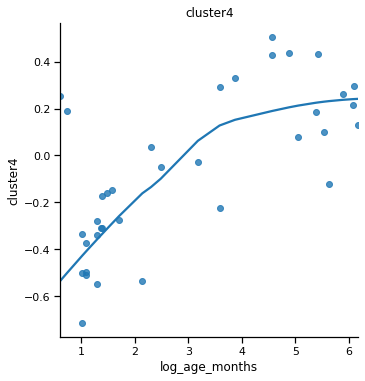

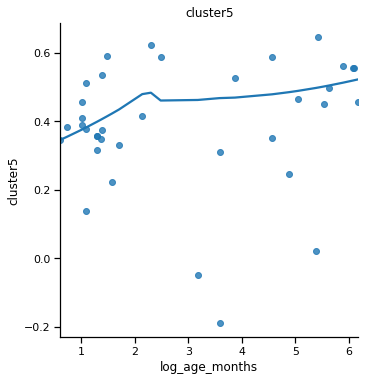

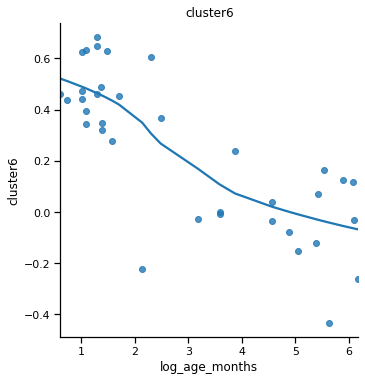

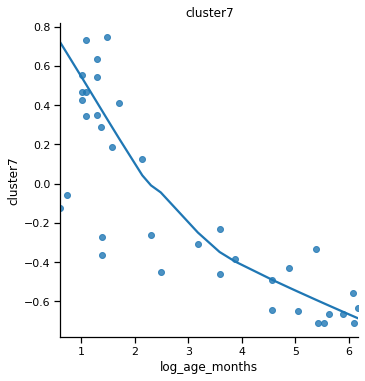

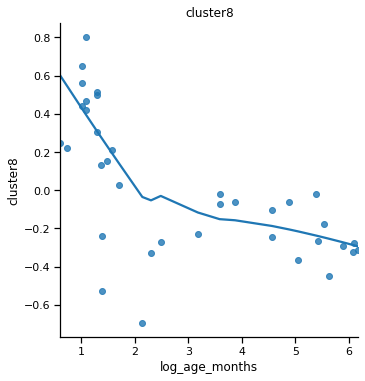

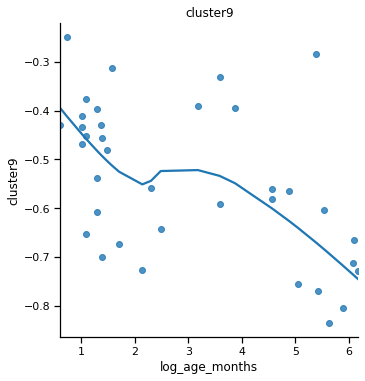

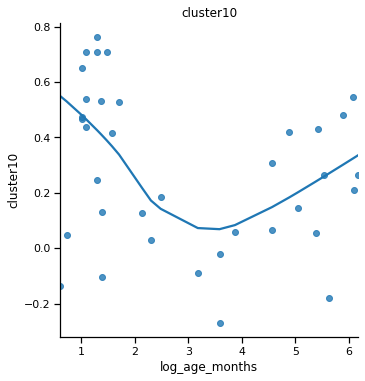

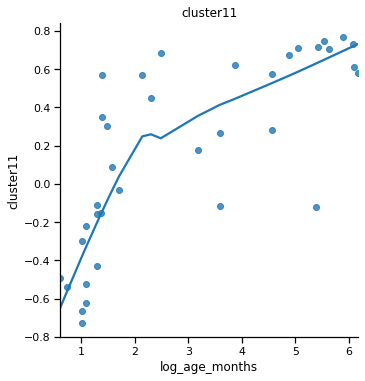

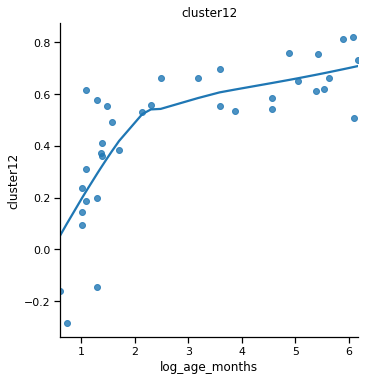

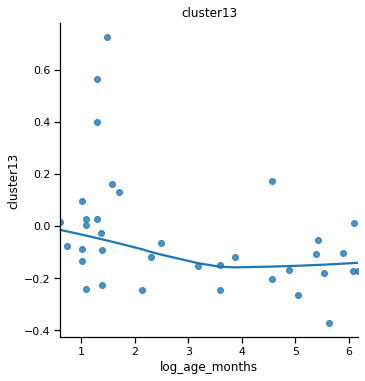

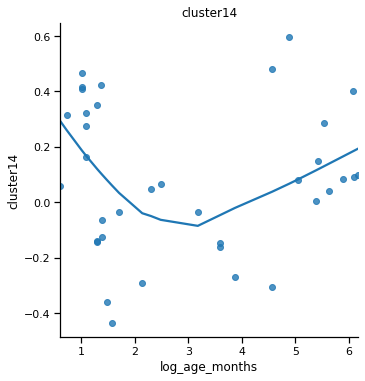

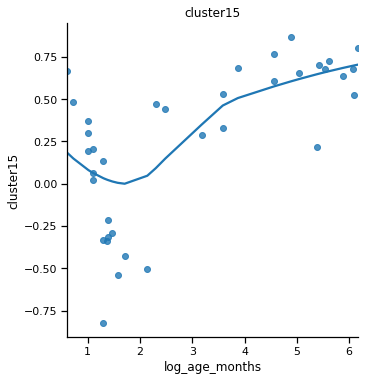

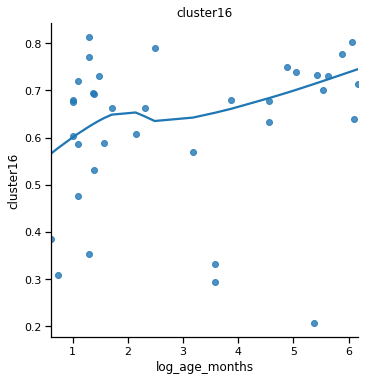

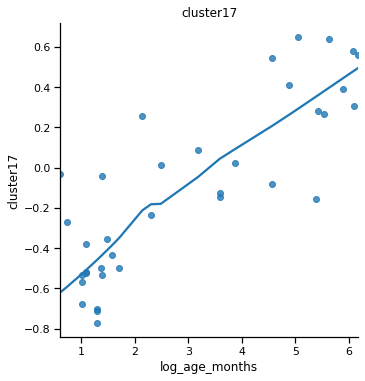

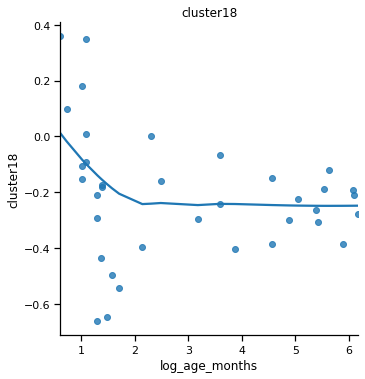

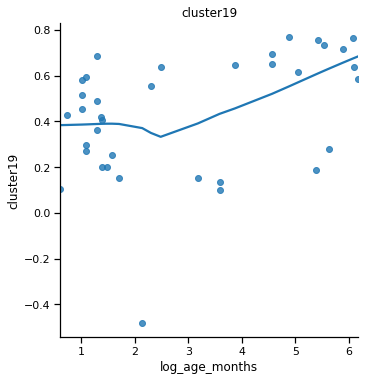

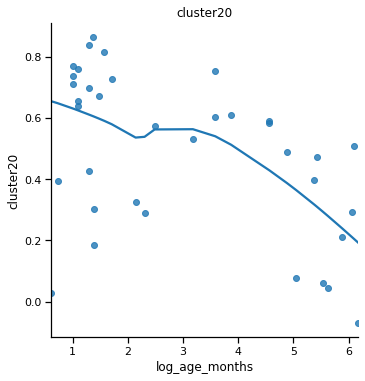

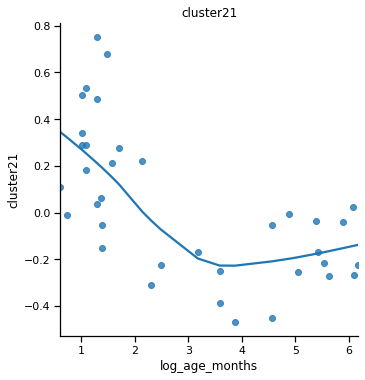

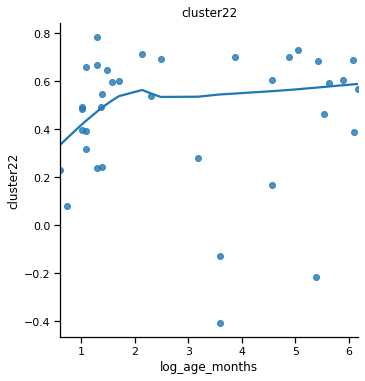

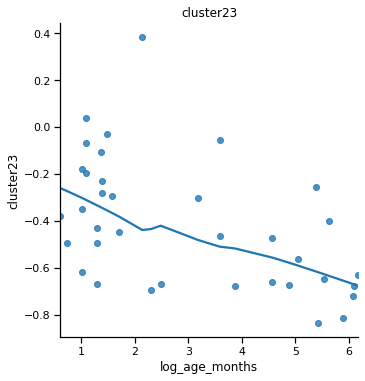

In [349]:
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    plt.title(cluster)
    plt.show()

In [360]:
cplots.loc[:,'ind'] = cplots.index

In [367]:
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_months'] = cplots.log_age_months.tolist() * len(tall.variable.unique())

In [375]:
colors = []
for clust in tall.variable.unique():
    r,p = stats.pearsonr(cplots[clust].values,cplots.log_age_months.values)
    if clust in ['cluster5','cluster16','cluster22']:
        colors.append('black')
    elif r < 0:
        colors.append('lightsteelblue')
    else:
        colors.append('lightcoral')

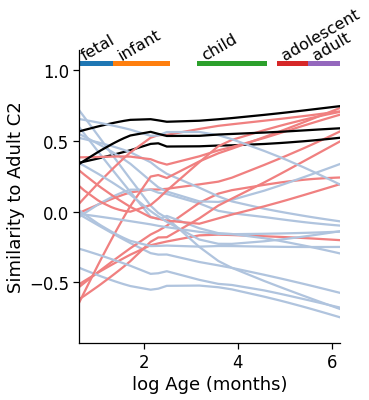

In [393]:
sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_months',y='value',
            hue='variable',lowess=True,
             markers='',palette=colors,
             legend=None,data=tall,)
plt.ylabel('Similarity to Adult C2')
plt.xlabel('log Age (months)')
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.savefig(os.path.join(fig_dir,'cluster_timelines.pdf'),bbox_inches='tight')

In [388]:
0.7*max(Y[:,2])

25.1629143386183

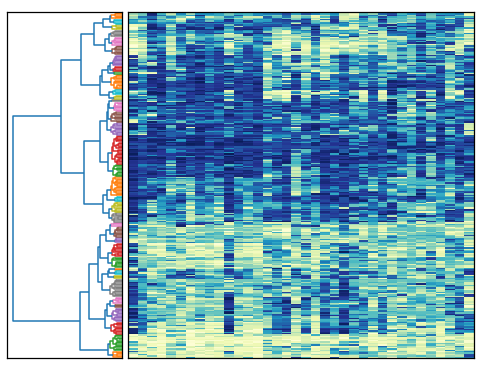

In [390]:
# Dendrogram that comes to the left

D = pandas.DataFrame(c2ss.T, copy=True)
D = D.values

fig = plt.figure(figsize=(8,8))
# Add an axes at position rect [left, bottom, width, height]
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
# orientation='left' is reponsible for making the 
# dendrogram appear to the left
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=4)
ax1.set_xticks([])
ax1.set_yticks([])


# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="YlGnBu")
axmatrix.set_xticks([])
axmatrix.set_yticks([])

plt.savefig(os.path.join(fig_dir,'Dendo.pdf'),bbox_inches='tight')
plt.show()

In [357]:
keepers = []
for clust in [5,16,22]:
    jnk = data[data.labels==clust]
    for x in jnk.index:
        j2 = x.split('_')[0]
        print(j2)
        keepers.append(j2)
    print('\n\n')

NRP1
HRH3
CLIC5
SLC27A6
AMIGO2
HDC
CDH11
SKAP1
PTPRF
LRRC36
FABP5
MEI1
SLC26A11
SGSH
DNAH14
EGFEM1P
GPX3



ZMYND10
MAOB
NKAIN4
RSPO4
FERMT1
TRPS1
VAT1
VWA5A
KCNA5
RGS22
SCN7A
SIX3
CXorf57
HSPB8
WDR66
DNALI1
HEYL
PCBD1
LRRN1
DBX2
HES5



CD38
ME1
GPR143
PLSCR4
PCDH17
PLOD2
MGAT4C
NWD1
SLC30A10





# Save for Bratislav's group

#### harmonized version

In [16]:
gxp.shape

(18503, 524)

In [17]:
rmd.shape

(47384, 5)

In [18]:
gxp.head()

1          2          3          4          5          6    \
TSPAN6    36.447128  24.251253  19.330479  27.668607  19.998231  14.680673   
TNMD       0.044081   0.067338   0.000000   0.145466   0.185188   0.311180   
DPM1      34.373239  20.765661  18.734947  22.366394  19.228431  11.020365   
SCYL3      4.379337   4.227521   2.551825   3.603764   2.948976   2.405183   
C1orf112   3.957119   3.520794   2.037805   3.487035   2.177235   0.999693   

                7          8          9          10   ...        515  \
TSPAN6    27.548101  16.580183  44.587799  44.943915  ...   2.320932   
TNMD       0.000000   0.000000   0.473831   0.181220  ...   0.758571   
DPM1      25.394607  17.671327  32.903100  38.157569  ...  23.769167   
SCYL3      3.613642   2.573935   3.483817   3.609830  ...   1.593009   
C1orf112   3.481555   1.747568   3.741580   3.560650  ...   0.583488   

                516        517        518        519        520        521  \
TSPAN6     1.781548   2.277359   1.832737   1.555696   2.081944   3.484685   
TNMD       0.000000   0.061869   0.026876   0.100691   0.140675   0.300576   
DPM1      20.142132  20.063257  16.575379  18.783516  21.631293  28.006120   
SCYL3      1.563377   1.648571   2.231466   2.040326   2.161741   1.275352   
C1orf112   0.797376   0.607141   0.575555   0.606445   0.683625   0.495084   

                522        523        524  
TSPAN6     4.816781   3.034464   3.082820  
TNMD       0.126526   0.000000   0.424134  
DPM1      28.731717  16.679597  28.866042  
SCYL3      1.184766   1.735579   1.500363  
C1orf112   0.761265   0.766482   0.468859  

[5 rows x 524 columns]

In [21]:
new_rmd = pandas.DataFrame(rmd,copy=True)

In [22]:
new_rmd.index = new_rmd.gene_symbol.values
new_rmd = new_rmd.loc[gxp.index]

In [23]:
new_rmd.shape

(18503, 5)

In [24]:
new_rmd.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata.csv',
              index=False)


In [31]:
new_rmd.head()

row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id
TSPAN6          1   7062.0  ENSG00000000003      TSPAN6     7105.0
TNMD            2  40735.0  ENSG00000000005        TNMD    64102.0
DPM1            3   8736.0  ENSG00000000419        DPM1     8813.0
SCYL3           4  36423.0  ENSG00000000457       SCYL3    57147.0
C1orf112        5  35021.0  ENSG00000000460    C1orf112    55732.0

In [29]:
gxp.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')


In [36]:
gxp = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')


In [37]:
gxp.columns = ['gene_symbol'] + list(range(len(gxp.columns)-1))

In [39]:
gxp.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv',
          index=False)

In [40]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')

gene_symbol           0           1           2           3  \
0             TSPAN6   36.447128   24.251253   19.330479   27.668607   
1               TNMD    0.044081    0.067338    0.000000    0.145466   
2               DPM1   34.373239   20.765661   18.734947   22.366394   
3              SCYL3    4.379337    4.227521    2.551825    3.603764   
4           C1orf112    3.957119    3.520794    2.037805    3.487035   
5                FGR    0.244174    0.266976    0.248188    0.141398   
6                CFH    1.739810    1.631157    1.505638    0.184312   
7              FUCA2   10.093235    7.413745    6.844418    8.241343   
8               GCLC    2.632164    2.350074    2.091245    1.970610   
9               NFYA   24.845660   27.283269   26.226790   26.843769   
10          C1orf201    0.433926    0.370707    0.733702    0.397208   
11            NIPAL3    1.363100    1.368581    3.363718    1.954944   
12             LAS1L   11.036951    8.939723    6.510241    7.494208   
13             ENPP4    2.243221    1.693700    2.697215    2.636313   
14            SEMA3F    3.673560    6.490515    8.551552    3.615563   
15              CFTR    0.005263    0.000000    0.044505    0.014686   
16            ANKIB1    6.807500    9.537955    9.159394    8.951021   
17           CYP51A1   37.608092   37.356446   26.622674   32.082002   
18             KRIT1    5.845881    6.340751    4.198716    5.185093   
19             RAD52    1.336437    1.873976    0.908440    1.511102   
20               BAD   20.377973   16.025971   24.642131   20.026298   
21              LAP3    7.365668    6.451070    3.973592    4.191359   
22            HS3ST1    0.194591    0.313840    0.841067    0.254977   
23              ABP1    0.000000    0.000000    0.000000    0.000000   
24             WNT16    0.121679    0.044856    0.161907    0.092458   
25             HECW1    3.598097    9.218532    5.552267    2.390078   
26            MAD1L1    5.535000    5.616777    6.133787    5.872899   
27             LASP1   61.602571   64.028878   95.647519   73.514245   
28             SNX11   11.271202    8.241802    8.617880    7.426295   
29          TMEM176A    0.168343    0.146931    0.101042    0.038330   
...              ...         ...         ...         ...         ...   
18473   RP11-477I4.3    0.349441    0.725405    0.425750    0.512675   
18474  RP11-537P22.1    0.957144    0.614746    1.259020    2.059322   
18475  RP11-404P21.6    0.000000    0.000000    0.000000    0.000000   
18476      ITPK1-AS1    0.000000    0.000000    0.000000    0.000000   
18477         OR4C13    0.000000    0.000000    0.000000    0.000000   
18478          KRT86    0.000000    0.000000    0.037396    0.007008   
18479           MC1R    0.821452    1.098753    1.293542    1.636771   
18480           DUXA    0.000000    0.000000    0.000000    0.000000   
18481          CEP95    7.177763   11.569297    5.527288    7.484177   
18482   RP11-33N16.1    1.005377    0.809600    0.490073    0.933428   
18483  RP11-566K11.2  181.124542  190.911956  346.488751  286.729864   
18484        TMEM179    1.296794    1.838100    4.517416    3.320381   
18485          TSPY1    0.000000    0.000000    0.000000    0.000000   
18486         DUX4L3    0.000000    0.000000    0.000000    0.000000   
18487  CTD-2303B20.1    0.000000    0.000000    0.000000    0.000000   
18488     AC027323.1    7.106517    4.823630    4.037243    4.311395   
18489          ITGB3    0.613023    0.405086    0.224634    0.512886   
18490            GH1    0.000000    0.000000    0.000000    0.080715   
18491          THTPA   10.625217    9.690860   11.201571   12.094830   
18492     RP11-2F9.2    0.000000    0.000000    0.000000    0.000000   
18493  RP11-625H11.1    0.000000    0.000000    0.000000    0.000000   
18494         KRT8P9    0.000000    0.000000    0.000000    0.000000   
18495  RP11-323F24.1    1.503525    1.852644    1.981111    1.932610   
18496  RP11-244F12.3    1.466229    1.389355    1

In [42]:
gdf.loc[:,'column_num'] = list(range(len(gdf)))

In [45]:
gdf.drop([x for x in gdf.columns if '_exp' in x],axis=1,inplace=True)


In [47]:
gdf.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/samples_metadata.csv',
          index=False)

#### original version

In [60]:
df = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/expression_matrix.csv',header=None)
rmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/rows_metadata.csv')

In [61]:
df.loc[:,0] = rmd.gene_symbol.values

In [65]:
df.columns = ['gene_symbol'] + list(range(len(cmd)))

In [68]:
rmd.loc[:,'row_num'] = range(len(rmd))

In [70]:
rmd.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata_original.csv',
          index=False)

In [73]:
df.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression_original.csv',
         index=False)

In [75]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression_original.csv'
               ).head()

gene_symbol          0          1          2          3          4  \
0      TSPAN6  36.447128  24.251253  19.330479  27.668607  19.998231   
1        TNMD   0.044081   0.067338   0.000000   0.145466   0.185188   
2        DPM1  34.373239  20.765661  18.734947  22.366394  19.228431   
3       SCYL3   4.379337   4.227521   2.551825   3.603764   2.948976   
4    C1orf112   3.957119   3.520794   2.037805   3.487035   2.177235   

           5          6          7          8  ...        514        515  \
0  14.680673  27.548101  16.580183  44.587799  ...   2.320932   1.781548   
1   0.311180   0.000000   0.000000   0.473831  ...   0.758571   0.000000   
2  11.020365  25.394607  17.671327  32.903100  ...  23.769167  20.142132   
3   2.405183   3.613642   2.573935   3.483817  ...   1.593009   1.563377   
4   0.999693   3.481555   1.747568   3.741580  ...   0.583488   0.797376   

         516        517        518        519        520        521  \
0   2.277359   1.832737   1.555696   2.081944   3.484685   4.816781   
1   0.061869   0.026876   0.100691   0.140675   0.300576   0.126526   
2  20.063257  16.575379  18.783516  21.631293  28.006120  28.731717   
3   1.648571   2.231466   2.040326   2.161741   1.275352   1.184766   
4   0.607141   0.575555   0.606445   0.683625   0.495084   0.761265   

         522        523  
0   3.034464   3.082820  
1   0.000000   0.424134  
2  16.679597  28.866042  
3   1.735579   1.500363  
4   0.766482   0.468859  

[5 rows x 525 columns]

In [76]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata_original.csv'
               ).head()

row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id
0        0   7062.0  ENSG00000000003      TSPAN6     7105.0
1        1  40735.0  ENSG00000000005        TNMD    64102.0
2        2   8736.0  ENSG00000000419        DPM1     8813.0
3        3  36423.0  ENSG00000000457       SCYL3    57147.0
4        4  35021.0  ENSG00000000460    C1orf112    55732.0

# Mouse gradients

In [64]:
homo = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/MouseHumanComp_Orig.csv',
                      index_col=0)
homo.head()

MouseC1   MouseC2   MouseC3   HumanC1   HumanC2   HumanC3
NRG2     0.006967  0.012442  0.005642  0.006455 -0.002230  0.013806
CAMTA1   0.014550  0.024123  0.051402  0.006785 -0.009396 -0.003544
DCUN1D4  0.010135 -0.005134  0.002363  0.001091 -0.000446  0.004482
NFXL1    0.003693 -0.000286  0.003713  0.008827  0.009024  0.000342
CPNE7   -0.010815 -0.047134  0.018085 -0.009136  0.004629 -0.007924

In [65]:
mous1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/GCorr_BSComp_MOUSE_C1_data.csv',
                       index_col=0)
mous1.columns = ['ABA_mean','ABA_sem']
sharecols = set(mous1.index) & set(gdf.MacroStructure2.unique())
print('shared:',sharecols)
print('missing:',set(gdf.MacroStructure2.unique()) - set(mous1.index))

shared: {'Cerebellum', 'Limbic', 'Frontal', 'Striatum', 'Thalamus', 'Temporal', 'Sensorimotor', 'Occipital', 'Parietal'}
missing: {'GangEm'}


In [66]:
shared = set(homo.index.values) & set(df[df.columns[0]].values)
bshomo = pandas.DataFrame(homo.loc[shared],copy=True)

In [67]:
df.index = df.gene_symbol.values
df.drop('gene_symbol',axis=1,inplace=True)

In [68]:
bshomo.head()

MouseC1   MouseC2   MouseC3   HumanC1   HumanC2   HumanC3
TGFB2  0.010122  0.000162  0.010190 -0.009598  0.003726  0.012057
MESP2  0.005991 -0.001588  0.003661  0.011337  0.004097  0.000406
TFDP2  0.043095  0.020234 -0.034889  0.000848  0.006365 -0.000434
ABTB1  0.012479  0.013416 -0.007702 -0.008953 -0.007071  0.004969
FGF17  0.002357 -0.001535  0.002710  0.001899 -0.014958  0.000691

In [69]:
for i in range(1,4):
    gdf.loc[:,'MouseC%s'%i] = np.dot(bshomo['MouseC%s'%i].values,df.loc[shared])

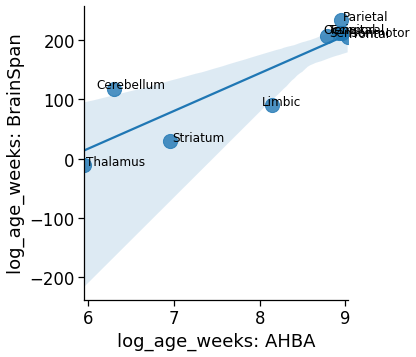

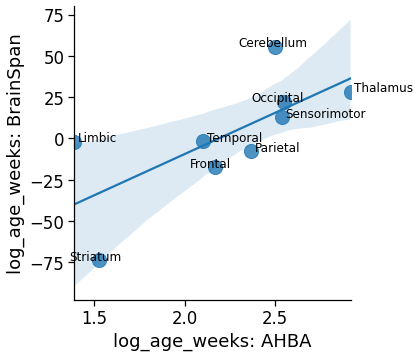

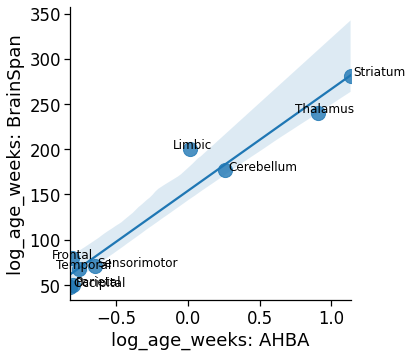

In [70]:
for i in range(1,4):
    aba = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/GCorr_BSComp_MOUSE_C%s_data.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    bs = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='MouseC%s'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['MouseC%s'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = sharecols
    
    sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200}
           #hue='region',legend=False,fit_reg=False
          )
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        #xsem = c2_comp.loc[div,'ABA_sem']
        y = comp.loc[div,'BS_mean']
        #ysem = c2_comp.loc[div,'BS_sem']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x+.02, y,div,{'size':12})
        else:
            plt.text(x-dist, y,div,{'size':12},
                     )
    #     plt.plot([x-xsem,x+xsem],[y,y],c='k')
    #     plt.plot([x,x],[y-ysem,y+ysem],c='k')
    plt.xlabel('%s: AHBA'%col)
    plt.ylabel('%s: BrainSpan'%col)
    plt.show()

#### Individual subject matching

In [148]:
gxp

0          1          2          3          4          5  \
TSPAN6    36.447128  24.251253  19.330479  27.668607  19.998231  14.680673   
DPM1      34.373239  20.765661  18.734947  22.366394  19.228431  11.020365   
SCYL3      4.379337   4.227521   2.551825   3.603764   2.948976   2.405183   
C1orf112   3.957119   3.520794   2.037805   3.487035   2.177235   0.999693   
FGR        0.244174   0.266976   0.248188   0.141398   0.467688   0.296493   
...             ...        ...        ...        ...        ...        ...   
SLC35G6    0.030182   0.000000   0.000000   0.000000   0.000000   0.014825   
GH1        0.000000   0.000000   0.000000   0.080715   0.000000   0.000000   
THTPA     10.625217   9.690860  11.201571  12.094830  10.376242   9.327033   
ANP32AP1  41.935201  52.451933  35.506476  35.755697  38.726738  22.715802   
BLID       0.000000   0.000000   0.051061   0.000000   0.000000   0.049086   

                  6          7          8          9  ...        514  \
TSPAN6    27.548101  16.580183  44.587799  44.943915  ...   2.320932   
DPM1      25.394607  17.671327  32.903100  38.157569  ...  23.769167   
SCYL3      3.613642   2.573935   3.483817   3.609830  ...   1.593009   
C1orf112   3.481555   1.747568   3.741580   3.560650  ...   0.583488   
FGR        0.079941   0.149822   0.204210   0.260205  ...   1.319251   
...             ...        ...        ...        ...  ...        ...   
SLC35G6    0.000000   0.018457   0.037863   0.000000  ...   0.000000   
GH1        0.000000   0.000000   0.000000   0.000000  ...   0.067709   
THTPA      9.917661  12.783277  12.309605  13.032196  ...  16.194193   
ANP32AP1  50.156694  24.878772  62.633439  45.910084  ...   3.070396   
BLID       0.000000   0.047359   0.000000   0.000000  ...   0.000000   

                515        516        517        518        519        520  \
TSPAN6     1.781548   2.277359   1.832737   1.555696   2.081944   3.484685   
DPM1      20.142132  20.063257  16.575379  18.783516  21.631293  28.006120   
SCYL3      1.563377   1.648571   2.231466   2.040326   2.161741   1.275352   
C1orf112   0.797376   0.607141   0.575555   0.606445   0.683625   0.495084   
FGR        2.062175   1.168233   0.681609   0.490367   0.407953   1.568014   
...             ...        ...        ...        ...        ...        ...   
SLC35G6    0.000000   0.000000   0.073606   0.038930   0.000000   0.000000   
GH1        0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
THTPA     17.851944  10.693976   9.858799  10.030765   8.465200  17.267813   
ANP32AP1   6.665558   6.178132   8.843410   9.073810   7.484486   4.270775   
BLID       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

                521        522        523  
TSPAN6     4.816781   3.034464   3.082820  
DPM1      28.731717  16.679597  28.866042  
SCYL3      1.184766   1.735579   1.500363  
C1orf112   0.761265   0.766482   0.468859  
FGR        1.260039   1.736395   1.632879  
...             ...        ...        ...  
SLC35G6    0.000000   0.041004   0.000000  
GH1        0.000000   0.000000   0.000000  
THTPA     21.401409  12.375088  16.954387  
ANP32AP1   2.020416  10.126426   3.915770  
BLID       0.179013   0.000000   0.000000  

[13750 rows x 524 columns]

In [71]:
gpdfs = {}
for i in range(1,4):
    gpdf = gdf[['donor_id','MouseC%s'%i,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='MouseC%s'%i)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [72]:
for c in range(1,4):
    cdf = gpdfs[c]
    aba = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/GCorr_BSComp_MOUSE_C%s_data.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-3]]
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5:
            forcorr.loc[:,'gvec'] = row.values[:-3]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [73]:
cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'new_age_gp', 'new_age_stage','age_in_months',
       'log_age_months']

In [74]:
gpdfs.keys()

dict_keys([1, 2, 3])

In [75]:
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

In [76]:
subsum.columns

Index(['donor_id', 'column_num', 'donor_name', 'age', 'gender', 'structure_id',
       'structure_acronym', 'structure_name', 'Age_Stage', 'Age_Epoch',
       'Age_Period', 'MacroStructure', 'MacroStructure2', 'NT_Segment',
       'Sensorifugal', 'age_level', 'new_age_gp', 'new_age_stage',
       'age_in_months', 'log_age_months', 'C1_r', 'C1_rho', 'n_valid', 'C2_r',
       'C2_rho', 'C3_r', 'C3_rho'],
      dtype='object')

In [77]:
subsum.iloc[[1,27]]

donor_id  column_num    donor_name     age gender  structure_id  \
1      12288         199    H376.IV.50  24 pcw      M         10294   
27     12888         105  H376.IIIA.52  13 pcw      M         10209   

   structure_acronym                                     structure_name  \
1                HIP                hippocampus (hippocampal formation)   
27               S1C  primary somatosensory cortex (area S1, areas 3...   

   Age_Stage Age_Epoch  ... new_age_stage age_in_months log_age_months  \
1      fetal        e2  ...         fetal      5.517241       1.707878   
27     fetal        e1  ...         fetal      2.988506       1.094774   

        C1_r    C1_rho  n_valid      C2_r    C2_rho      C3_r    C3_rho  
1   0.883804  0.714286      9.0  0.749747  0.785714  0.913272  0.785714  
27  0.891452  0.714286      8.0  0.643420  0.642857  0.882691  0.857143  

[2 rows x 27 columns]

In [78]:
homo.sort_values('HumanC1')['HumanC1'].head(20)

FOXG1      -0.036079
NR2E1      -0.030994
WNT10A     -0.030042
PRRX1      -0.029574
KLHL29     -0.028756
HDC        -0.027646
GDA        -0.027081
OTX1       -0.026949
DLX1       -0.026397
EGR3       -0.026187
GDF10      -0.026015
ARHGAP25   -0.025884
RXFP1      -0.025813
COL5A2     -0.024649
PCDH10     -0.024625
ARX        -0.024588
EMX2       -0.023879
EPHB6      -0.023710
LHX2       -0.023577
GRID1      -0.023405
Name: HumanC1, dtype: float64

In [79]:
homo.sort_values('MouseC1')['MouseC1'].tail(10)

SOX15      0.081993
FOXG1      0.085357
EGR3       0.086980
STX1A      0.089493
ENC1       0.094101
NGEF       0.102973
REST       0.105591
ICAM5      0.115728
MEF2C      0.116126
SLC17A7    0.123420
Name: MouseC1, dtype: float64

r=-0.433, p=0.0084


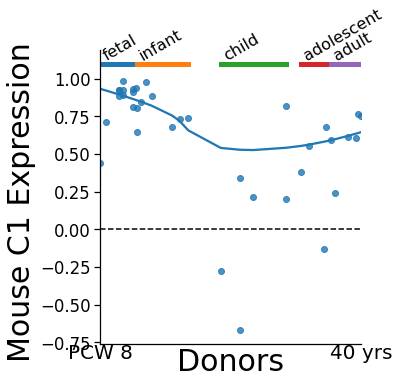

r=-0.446, p=0.0064


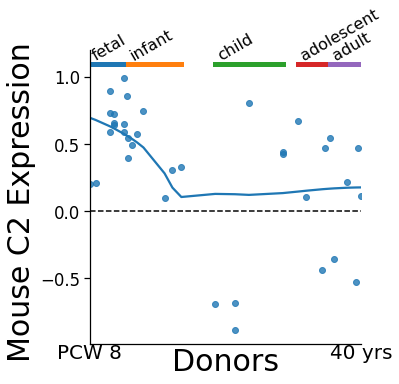

r=-0.059, p=0.7325


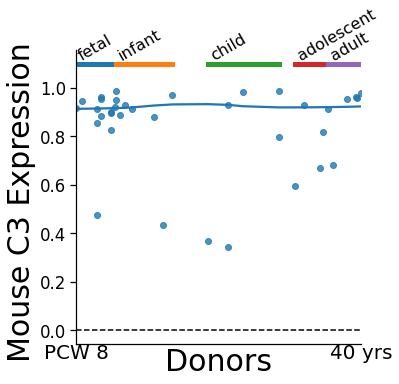

In [84]:
for c in range(1,4):
    g=sns.lmplot(x='log_age_months',y='C%s_r'%c,
                #hue='SEX',
                lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'log_age_months']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.log_age_months.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    g.set_xticklabels(rotation=90)
    g.set_xticklabels(rotation=90)
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    plt.ylabel('Mouse C%s Expression '%c,fontsize=30)
    # plt.yticks([])
    plt.xlabel('Donors',fontsize=30)
    plt.xticks([])
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
         transform=g.ax.transAxes)
    plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
             transform=g.ax.transAxes)
    plt.axhline(0,ls='--',c='k')
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/BrSp_CompR_C%s.pdf'%c,
#                bbox_inches='tight')
    plt.show()
    
#     # rho
#     g=sns.lmplot(x='age_level',y='C%s_rho'%c,
#                 #hue='SEX',
#                 lowess=True,
#                data=subsum)
#     plotr = pandas.DataFrame(subsum[['C%s_rho'%c,'age_level']],
#                             copy=True).dropna()
#     r,p=stats.pearsonr(plotr['C%s_rho'%c].values,
#                       plotr.age_level.values)
#     print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
#     g.set_xticklabels(rotation=90)
#     g.set_xticklabels(rotation=90)
#     for stage in gdf.Age_Stage.unique():
#         levels = gdf[gdf.Age_Stage==stage]['age_level'].values
#         xmin = np.min(levels)
#         xmax = np.max(levels)
#         plt.plot([xmin,xmax],[1.1,1.1],lw=5)
#         #loc = xmin + (xmax-xmin)*.5
#         plt.text(xmin,1.1,stage,fontsize=16,ha='left',
#                  va='bottom',rotation=30)
#     plt.ylabel('C%s Expression'%c,fontsize=30)
#     # plt.yticks([])
#     plt.xlabel('Donors',fontsize=30)
#     plt.xticks([])
#     ymin = subsum['C%s_r'%c].min() - 0.1
#     plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
#          transform=g.ax.transAxes)
#     plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
#              transform=g.ax.transAxes)
#     plt.show()


In [195]:
jnk = pandas.DataFrame(subsum[['age_level', 'age_in_months', 'log_age_months',
                               'age_in_weeks', 'log_age_weeks']],
                       copy=True)
jnk.loc[:,'r'] = subsum.C1_r.values
jnk.loc[:,'Component'] = 'MouseC1'
mdev = pandas.concat([devplot,jnk])
mdev.loc[mdev.Component=='1','Component'] = 'HumanC1'

In [203]:
mdev[mdev.Component.isin(['HumanC1','MouseC1'])]

r Component  age_level  age_in_months  log_age_months  \
0   0.390957   HumanC1          4       3.678161        1.302413   
1   0.334260   HumanC1          8       5.517241        1.707878   
2   0.925297   HumanC1         20     132.000000        4.882802   
3   0.924965   HumanC1         27     360.000000        5.886104   
4        NaN   HumanC1         11       8.045977        2.085172   
..       ...       ...        ...            ...             ...   
37  0.781859   MouseC1         23     216.000000        5.375278   
38  0.840106   MouseC1         25     252.000000        5.529429   
39 -0.633127   MouseC1          0       1.839080        0.609266   
40 -0.359672   MouseC1          2       2.758621        1.014731   
41  0.900411   MouseC1         12       8.505747        2.140742   

    age_in_weeks  log_age_weeks  
0         16.000       2.772589  
1         24.000       3.178054  
2        611.105       6.415269  
3       1599.105       7.377199  
4         35.000       3.555348  
..           ...            ...  
37       975.105       6.882545  
38      1131.105       7.030950  
39         8.000       2.079442  
40        12.000       2.484907  
41        37.000       3.610918  

[84 rows x 7 columns]

Text(0.5, 15.439999999999998, 'log Age (weeks)')

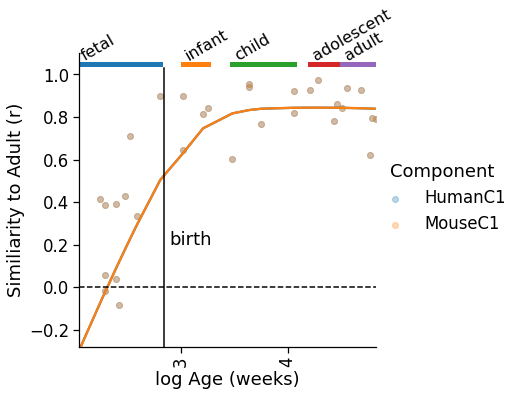

In [202]:
g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1.1,
             #hue_order=['1','2','3'],palette='binary',
               data=mdev[mdev.Component.isin(['HumanC1','MouseC1'])],
             scatter_kws={'alpha':0.3})
g.ax.set_ylim(-0.3,1.08)
g.set_xticklabels(rotation=90)
# for i in range(3):
#     # make line purty
#     x, y = g.ax.get_lines()[i].get_data()
#     segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
#     norm = plt.Normalize(x.min(), x.max())
#     lc = LineCollection(segments, cmap=pals[i], norm=norm)
#     lc.set_array(x[:-1])
#     lc.set_linewidth(2)
#     line = g.ax.add_collection(lc)
#     plt.setp(line,linewidth=5)
# for i in range(3):
#     g.ax.get_lines()[0].remove()

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,ls='--',c='k')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.2,'birth')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BrSp_CompR_overlay.pdf'),bbox_inches='tight')

In [464]:
from difflib import get_close_matches

ebps = get_close_matches('EIF4EBP',gxp.index)
for ebp in ebps:
    gdf.loc[:,ebp] = gxp.loc[ebp].values

In [477]:
ebps

['EIF4EBP2', 'EIF4EBP1', 'EIF4E1B']

In [471]:
cols = ebps + ['log_age_months','MacroStructure']
jnk = pandas.DataFrame(gdf[cols],copy=True)
jnk.loc[:,'ind'] = range(len(jnk))
tall = jnk.melt('ind',ebps,'EBP','expr')
for col in ['log_age_months','MacroStructure']:
    tall.loc[:,col] = jnk[col].tolist() * 3

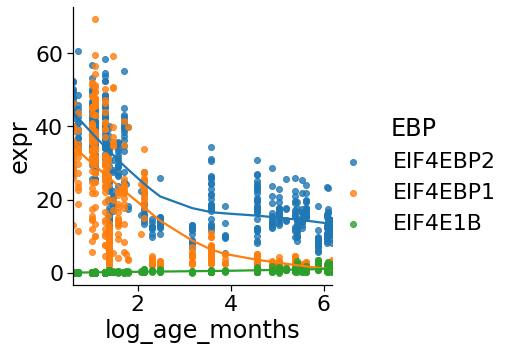

In [474]:
sns.lmplot(x='log_age_months',y='expr',hue='EBP',lowess=True,
          data=tall)

===== Occipital =====


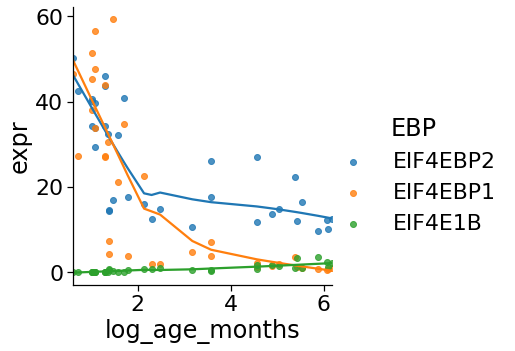

===== Somatomotor =====


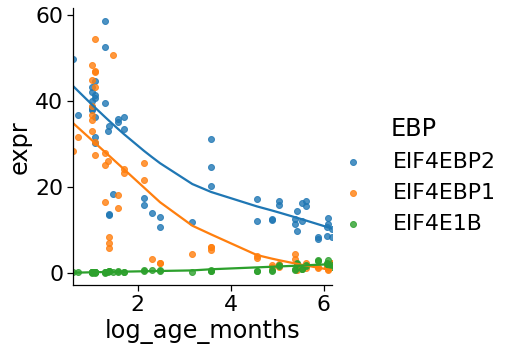

===== Limbic =====


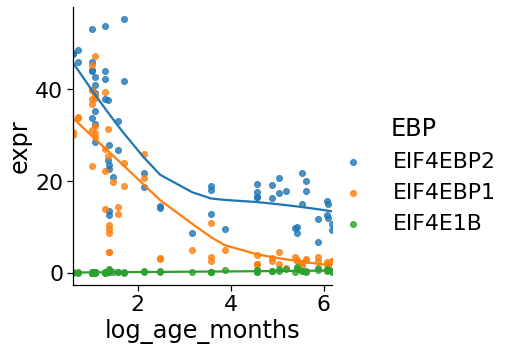

===== GangEm =====


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in greater_equal
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in greater_equal
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in greater_equal
  frac=frac, it=it, delta=delta, given_xvals=False)


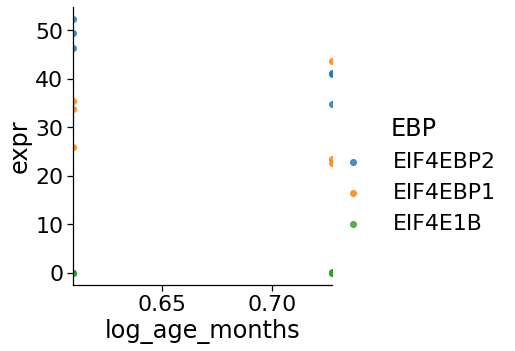

===== Temporal =====


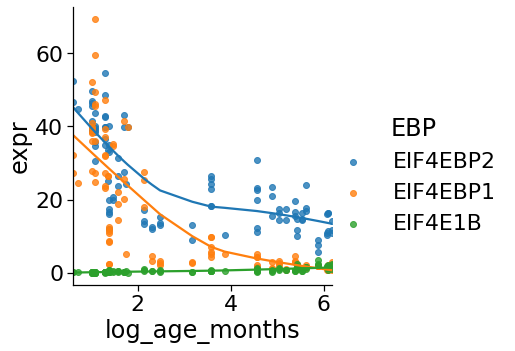

===== Cerebellum =====


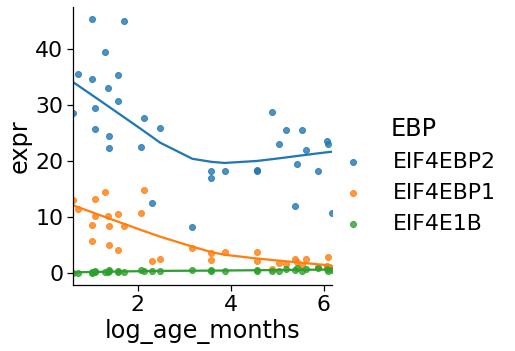

===== Subcortex =====


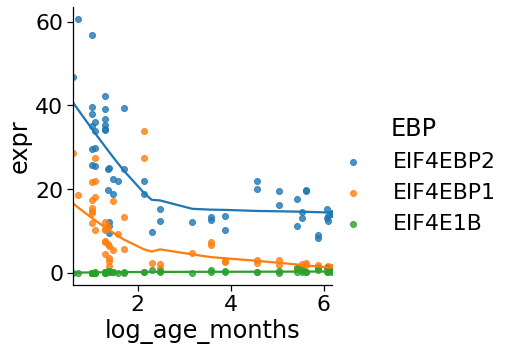

===== Frontal =====


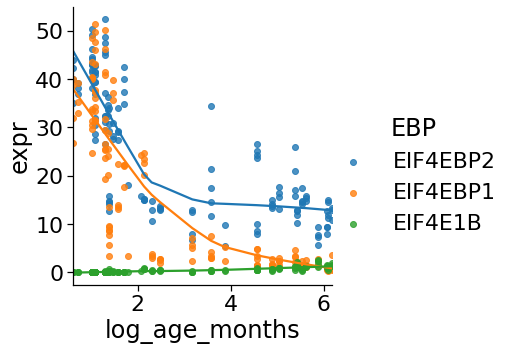

===== Parietal =====


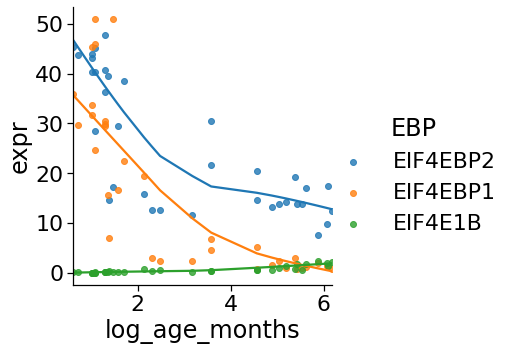

In [475]:
for region in jnk.MacroStructure.unique():
    print('='*5,region,'='*5)
    sns.lmplot(x='log_age_months',y='expr',hue='EBP',lowess=True,
          data=tall[tall.MacroStructure==region])
    plt.show()

In [ ]:

gxp.loc